In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
from scipy.optimize import curve_fit

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Global COVID-19 Analysis

In [5]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases



Total number of cases (in countries with at least 100 cases) as of 4/2/20


4/2/20
Country/Region        
US              243453
Italy           115242
Spain           112065
Germany          84794
China            82432
...                ...
Kosovo             125
Bolivia            123
Kyrgyzstan         116
Cambodia           110
Kenya              110

[112 rows x 1 columns]

## US State Measures

In [15]:
import requests

location_state_list = []
location_hashmap = dict()

def process_locations():
    r = requests.get("https://covid19.healthdata.org/api/metadata/location")
    j = r.json()
    
    for loc in j:
        if loc.get("location_name") == "United States of America":
            continue
        
        location_hashmap[loc.get("location_name")] = loc["location_id"]
        location_state_list.append(loc.get("location_name"))

process_locations()

measures_taken_per_state = dict()

def fetch_state_info(state):
    location_id = location_hashmap.get(state)
    
    intervention_url = 'https://covid19.healthdata.org/api/data/intervention?location='+str(location_id)

    r = requests.get(intervention_url)
    j = r.json()
    
    measures_taken_per_state[state] = []

    for intervention in j:
        date_format = "%Y-%m-%d %H:%M:%S"
        
        measures_taken_per_state[state].append(dict(
            measure=intervention["covid_intervention_measure_name"],
            reported=datetime.strptime(intervention["date_reported"], date_format)
        ))
    
    return measures_taken_per_state[state]

def populate_locations():
    for state in location_state_list:
        print("Processing state measures", state)
        fetch_state_info(state)
    
    no_measure_states = []
    one_measure_states = []
    two_measure_states = []
    
    for state in location_state_list:
        if len(measures_taken_per_state.get(state)) == 0:
            no_measure_states.append(state)
        if len(measures_taken_per_state.get(state)) == 1:
            one_measure_states.append(state)
        if len(measures_taken_per_state.get(state)) == 2:
            two_measure_states.append(state)
    
    states_without_stay_at_home = []
    
    for state in location_state_list:
        no_stay_at_home = True
        for measure in measures_taken_per_state.get(state):
            if measure["measure"] == "People instructed to stay at home":
                no_stay_at_home = False
        
        if no_stay_at_home:
            states_without_stay_at_home.append(state)
            
    states_without_closures = []
    
    for state in location_state_list:
        no_closures = True
        for measure in measures_taken_per_state.get(state):
            if measure["measure"] == "Non-essential services closed (i.e., bars/restaurants)":
                no_closures = False
        
        if no_closures:
            states_without_closures.append(state)
            
        
            
    print("0 measure States:")
    print(", ".join(no_measure_states))
    print("1 measure States:")
    print(", ".join(one_measure_states))
    print("2 measure States:")
    print(", ".join(two_measure_states))
    
    print("States without stay at home orders:")
    print(", ".join(states_without_stay_at_home))
    
    print("States without closures of non-essential services:")
    print(", ".join(states_without_closures))

populate_locations()

def get_state_measures(state):
    return measures_taken_per_state.get(state, None)


Processing state measures Alabama
Processing state measures Alaska
Processing state measures Arizona
Processing state measures Arkansas
Processing state measures California
Processing state measures Colorado
Processing state measures Connecticut
Processing state measures Delaware
Processing state measures District of Columbia
Processing state measures Florida
Processing state measures Georgia
Processing state measures Hawaii
Processing state measures Idaho
Processing state measures Illinois
Processing state measures Indiana
Processing state measures Iowa
Processing state measures Kansas
Processing state measures Kentucky
Processing state measures Louisiana
Processing state measures Maine
Processing state measures Maryland
Processing state measures Massachusetts
Processing state measures Michigan
Processing state measures Minnesota
Processing state measures Mississippi
Processing state measures Missouri
Processing state measures Montana
Processing state measures Nebraska
Processing stat

## Curve Fitting Global COVID-19 Cases

In [14]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    x_pred = np.arange(y.size+21) # 3 weeks into the future
    
    # Only predict based on figures above 10
    skip_days = 0
    
    for day in range(len(y)):
        cases = y[day]
        
        if cases > 10:
            skip_days = day
            break
    
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(20,10))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    # Draw our skip days line
    plt.axvline(x=skip_days,label="Fit after this")
    
    # Draw our date lines
    plt.axvline(x=y.size,label=mostrecentdate,color="pink")
    most_recent_date_as_index = y.size-1
    date_format = "%m/%d/%y"
    aus_date_format = "%d/%m/%y"
    most_recent_date_as_date = datetime.strptime(mostrecentdate, date_format)
    
    in_7_days_date = most_recent_date_as_date+timedelta(days=7)
    in_14_days_date = most_recent_date_as_date+timedelta(days=14)

    plt.axvline(x=most_recent_date_as_index+7,label=in_7_days_date.strftime(aus_date_format),color="orange")
    plt.axvline(x=most_recent_date_as_index+14,label=in_14_days_date.strftime(aus_date_format),color="purple")
    
    # Check if this state has had measures taken
    state_measures = get_state_measures(country)
    
    if not state_measures == None:
        for measure in state_measures:
            days_before_latest = (most_recent_date_as_date - measure["reported"]).days
            index_of_measure = most_recent_date_as_index - days_before_latest
            
            plt.axvline(x=index_of_measure,label=measure["measure"] + " on " +  measure["reported"].strftime(aus_date_format),color="green")
        
    try:
        lpopt, lpcov = curve_fit(logistic, x[skip_days:], y[skip_days:], maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x_pred, logistic(x_pred, lpopt[0], lpopt[1]-lerror[1], lpopt[2], lpopt[3]), 'b--', label="LgstcCrv Fit Low")
            plt.plot(x_pred, logistic(x_pred, lpopt[0], lpopt[1]+lerror[1], lpopt[2], lpopt[3]), 'b--', label="LgstcCrv Fit High")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tSkipping', skip_days, "days")
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x[skip_days:], y[skip_days:], bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x_pred, exponential(x_pred, epopt[0], epopt[1]-eerror[1], epopt[2]), 'r--', label="ExpCrv Fit Low")
            plt.plot(x_pred, exponential(x_pred, epopt[0], epopt[1]+eerror[1], epopt[2]), 'r--', label="ExpCrv Fit High")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tSkipping', skip_days, "days")
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.yscale('log')
    plt.ylim(bottom=1)
    
    

    
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 243453
	Confirmed cases on 3/26/20 	 83836
	Ratio: 2.9
	Weekly increase: 190.4 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Exponential Fit **

	R^2: 0.9921039300534396
	Skipping 12 days
	Doubling Time (represents overall growth):  4.02 (± 0.2 ) days


Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 115242
	Confirmed cases on 3/26/20 	 80589
	Ratio: 1.43
	Weekly increase: 43.0 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.999523516341662
	Skipping 21 days
	Doubling Time (during middle of growth):  7.99 (± 0.25 ) days


Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 5116
	Confirmed cases on 3/26/20 	 2810
	Ratio: 1.82
	Weekly increase: 82.1 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 da

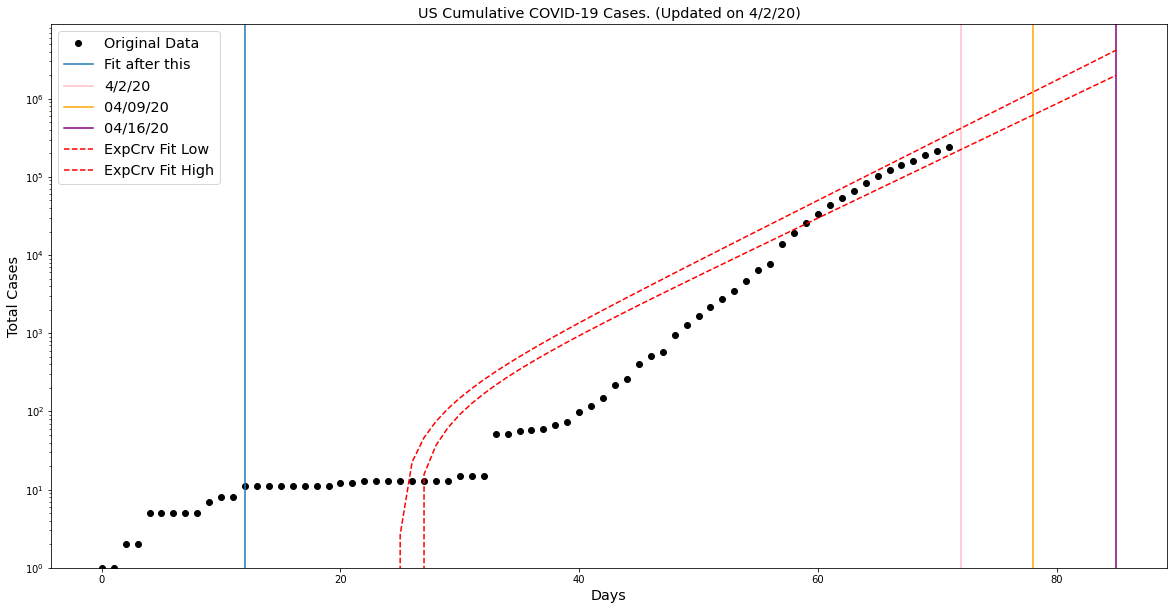

/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


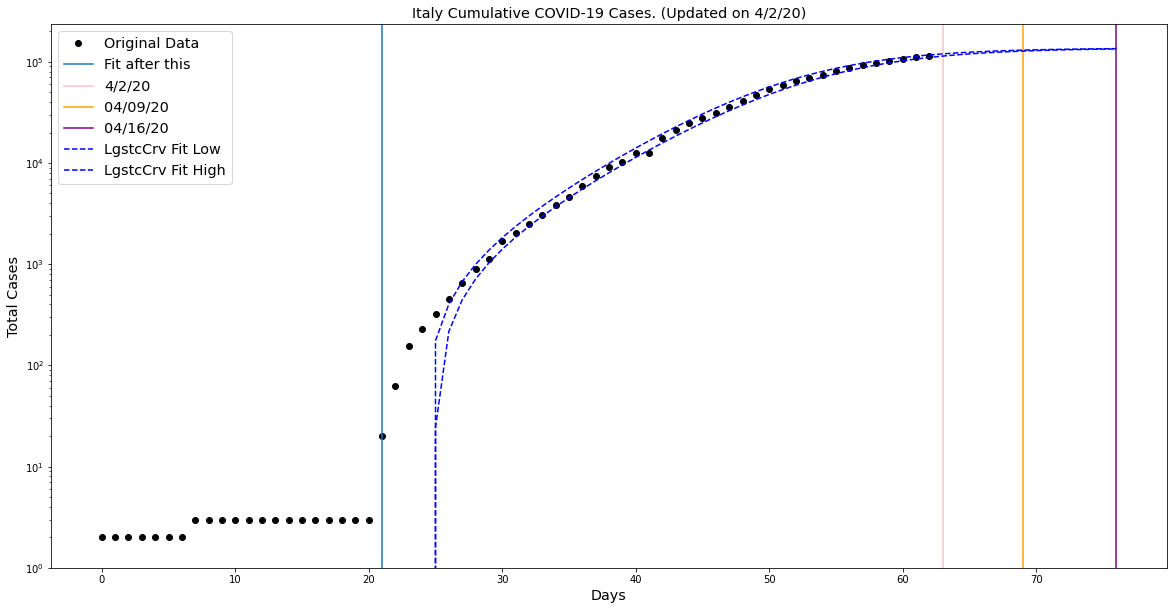

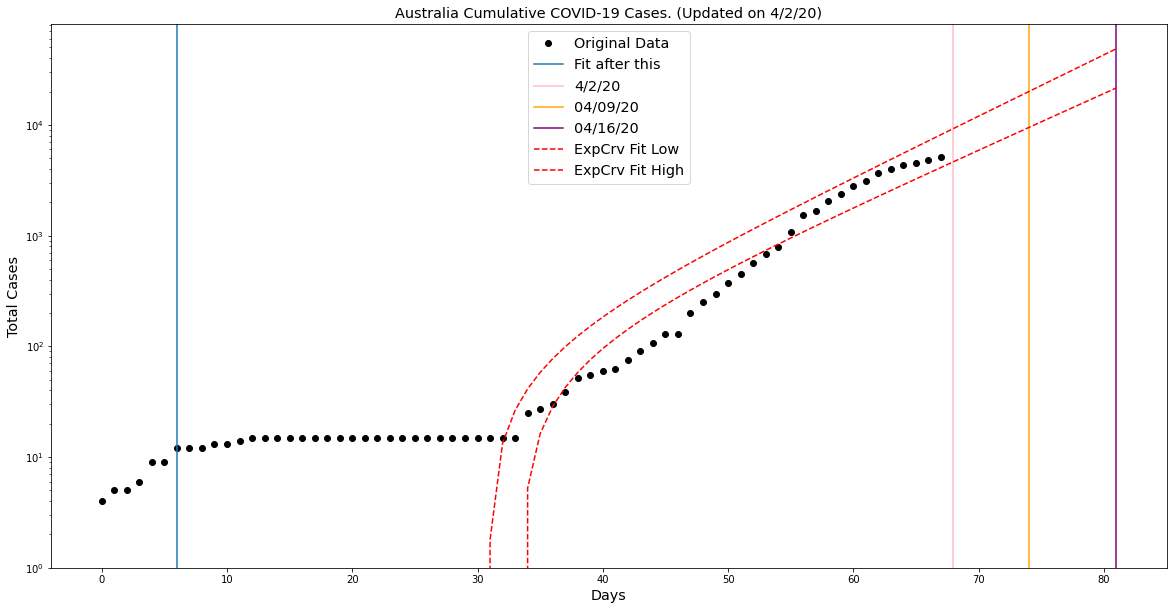

In [8]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    
    if c != "US" and c != "Australia" and c != "Italy":
        continue
    
    print(c)
        
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


   Inferred Doubling Time  95%CI  Recent Doubling Time
0                     4.0    0.2                   4.6
1                     8.0    0.2                  13.6
2                     5.7    0.5                   8.1










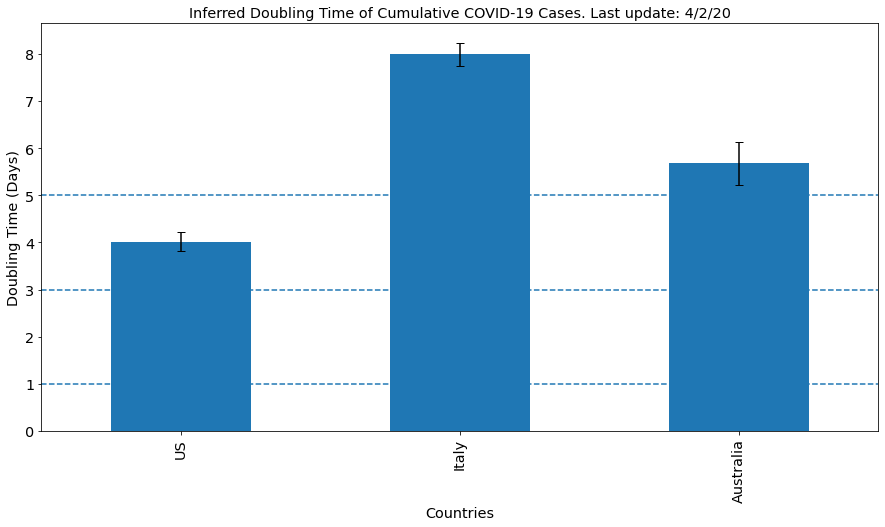

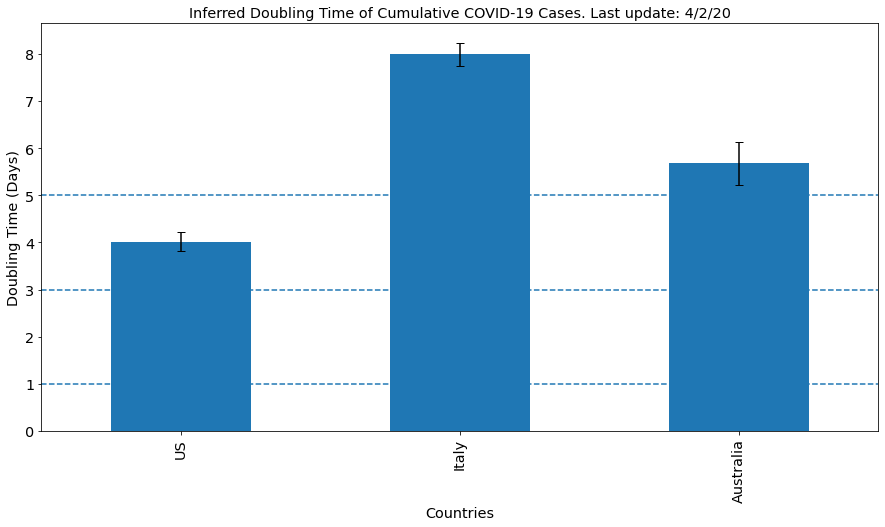

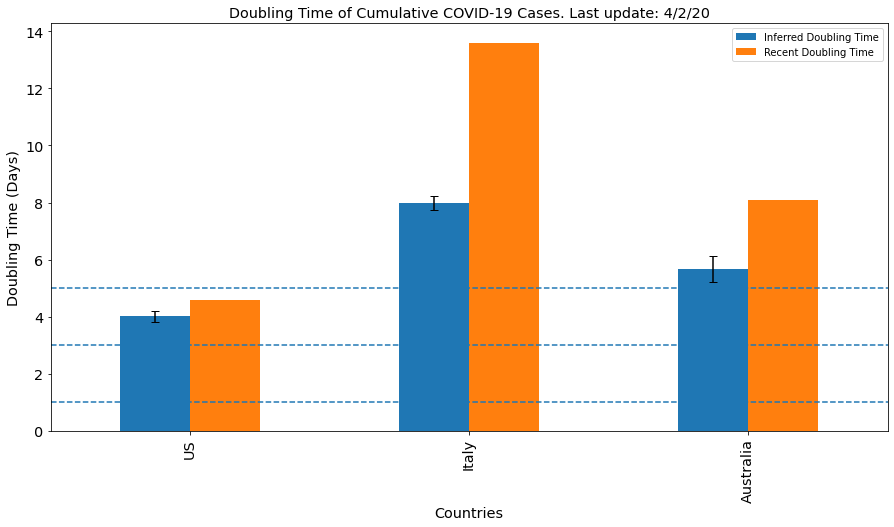

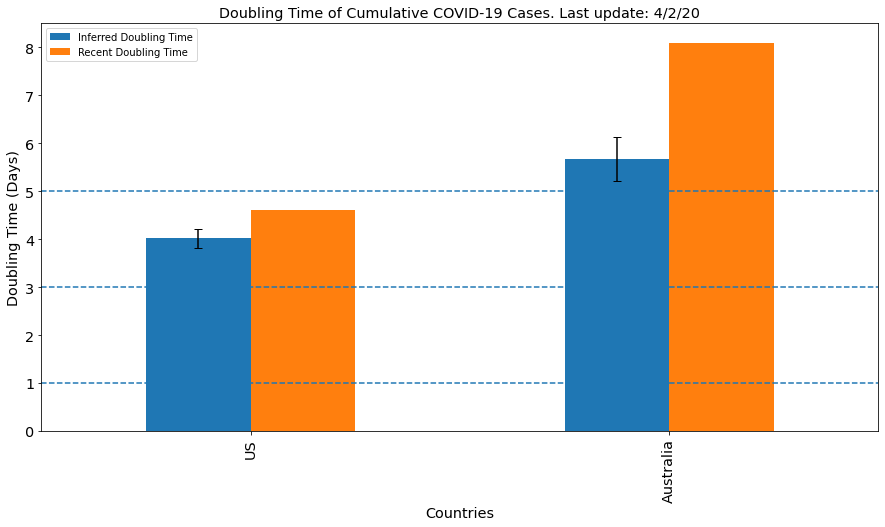

In [9]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [12]:
uscases = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

# For some reason they change column names, change them back.
uscases.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)


# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

# global
# Province/State,Country/Region,Lat,Long,1/22/20

# US
# UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/2020

# Province/State  Country/Region      Lat     Long  1/22/20
uscases = uscases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'])

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 4/2/20


4/2/20
Province/State                  
New York                   92506
New Jersey                 25590
Michigan                   10791
California                 10773
Louisiana                   9159
Florida                     9008
Massachusetts               8966
Illinois                    7695
Pennsylvania                7268
Washington                  6389
Georgia                     5348
Texas                       5069
Connecticut                 3824
Colorado                    3342
Indiana                     3038
Ohio                        2901
Tennessee                   2845
Maryland                    2331
North Carolina              1977
Missouri                    1857
Wisconsin                   1748
Arizona                     1715
Virginia                    1706
South Carolina              1554
Nevada                      1463
Alabama                     1233
Mississippi                 1177
Utah                        1092
Oklahoma                     881
Oregon                       826
Idaho                        776
Kentucky                     770
Minnesota                    742
Rhode Island                 657
District of Columbia         653
Arkansas                     643
Iowa                         614
Kansas                       553
Delaware                     393
New Mexico                   388
Maine                        376
Vermont                      338
Puerto Rico                  316
New Hampshire                316
Hawaii                       256
Nebraska                     246
Montana                      241
West Virginia                216
South Dakota                 165
North Dakota                 159
Wyoming                      150
Alaska                       143
Grand Princess               103
Guam                          82
Diamond Princess              49
Virgin Islands                30
Northern Mariana Islands       6

## Curve Fitting US COVID-19 Cases

                      4/2/20
Province/State              
New York               92506
New Jersey             25590
Michigan               10791
California             10773
Louisiana               9159
Florida                 9008
Massachusetts           8966
Illinois                7695
Pennsylvania            7268
Washington              6389
Georgia                 5348
Texas                   5069
Connecticut             3824
Colorado                3342
Indiana                 3038
Ohio                    2901
Tennessee               2845
Maryland                2331
North Carolina          1977
Missouri                1857
Wisconsin               1748
Arizona                 1715
Virginia                1706
South Carolina          1554
Nevada                  1463
Alabama                 1233
Mississippi             1177
Utah                    1092
Oklahoma                 881
Oregon                   826
Idaho                    776
Kentucky                 770
Minnesota     

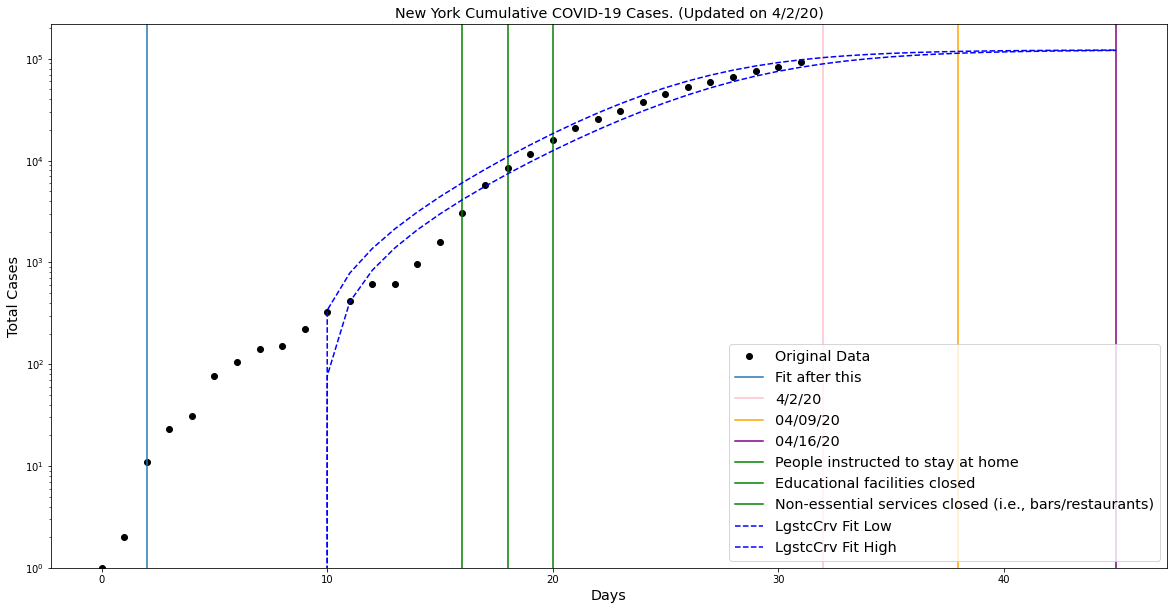

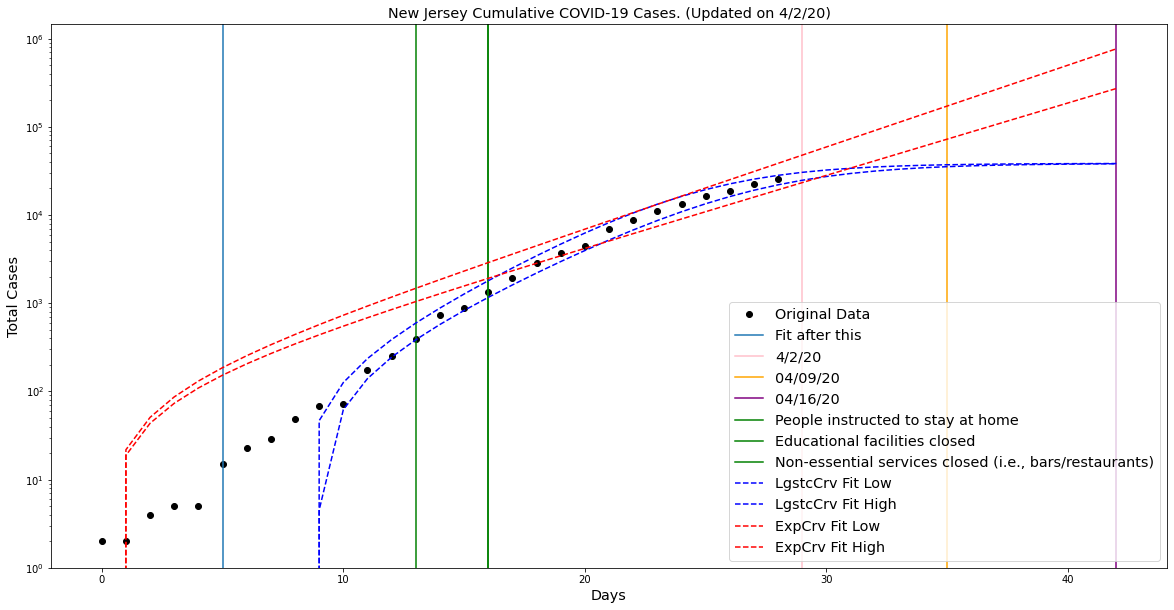

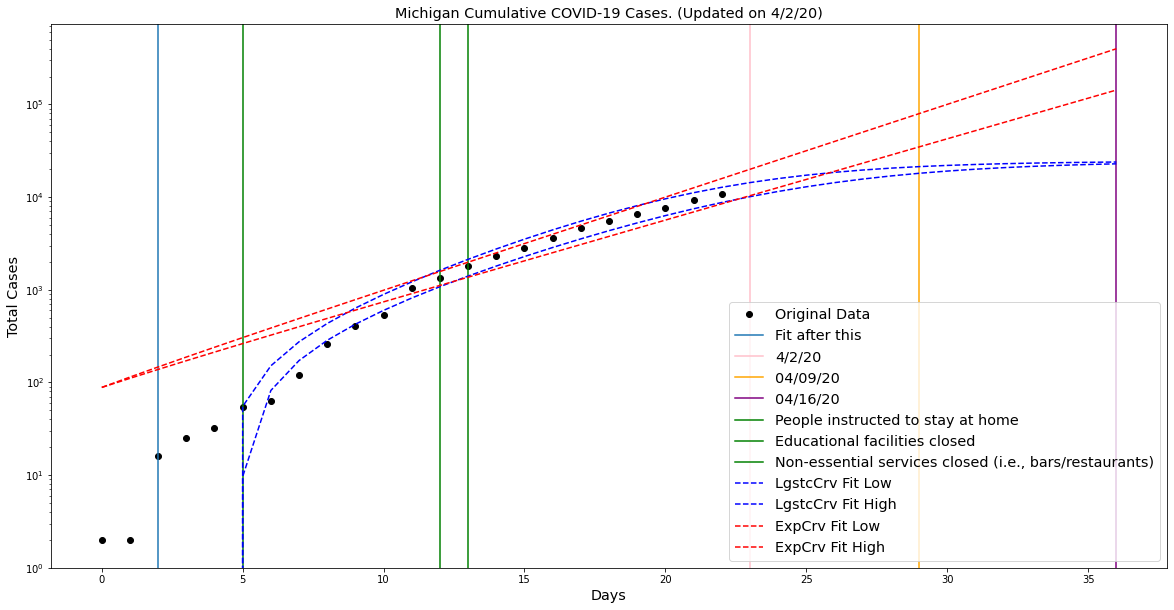

/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


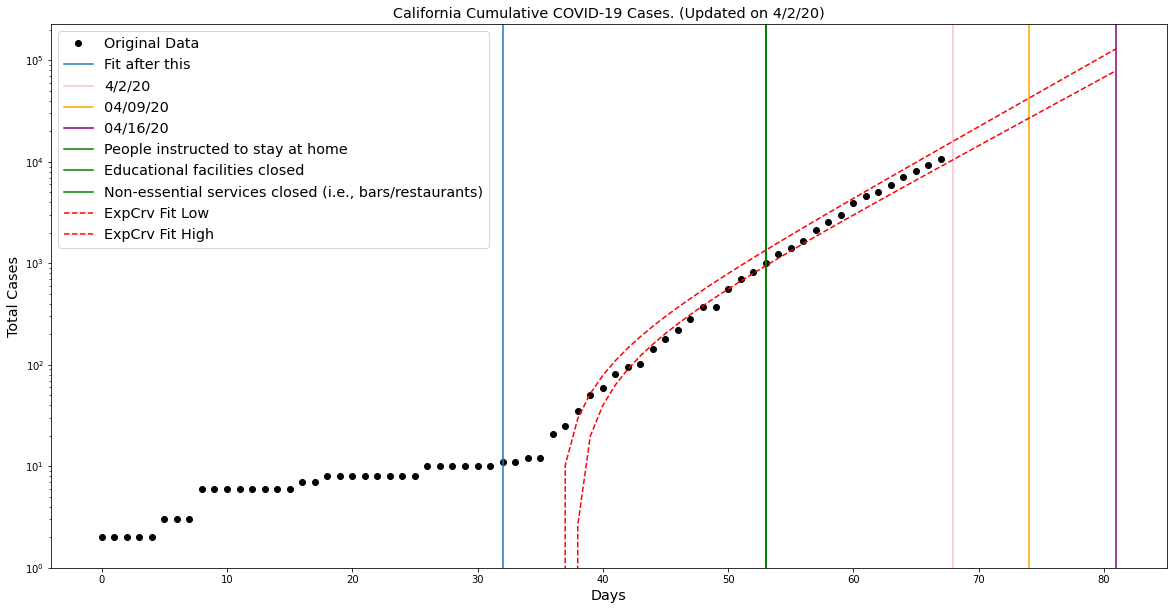

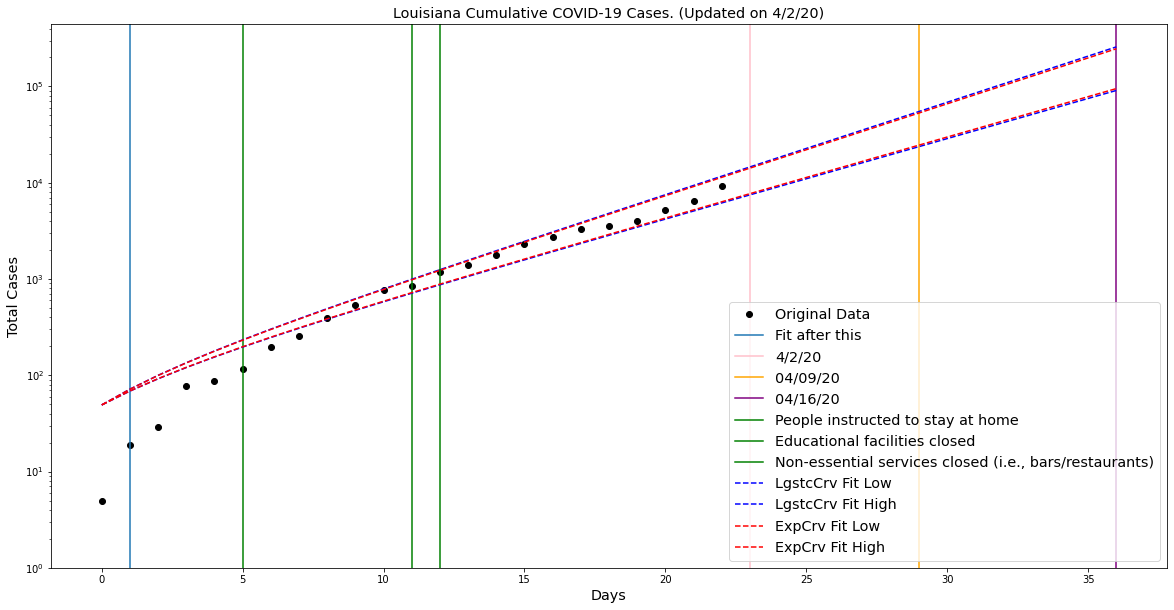

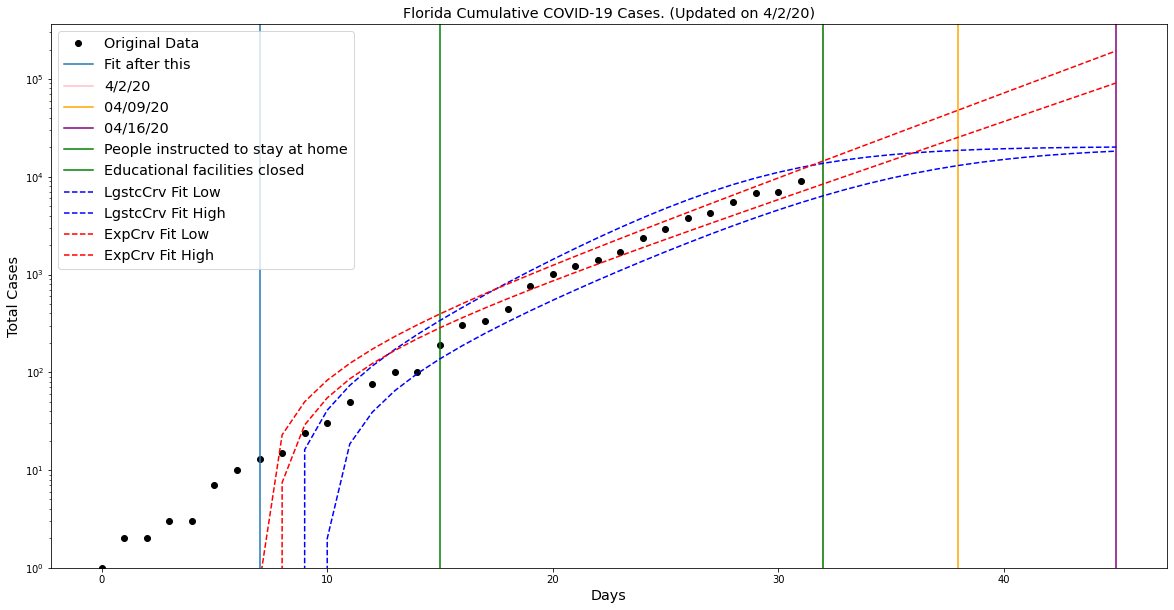

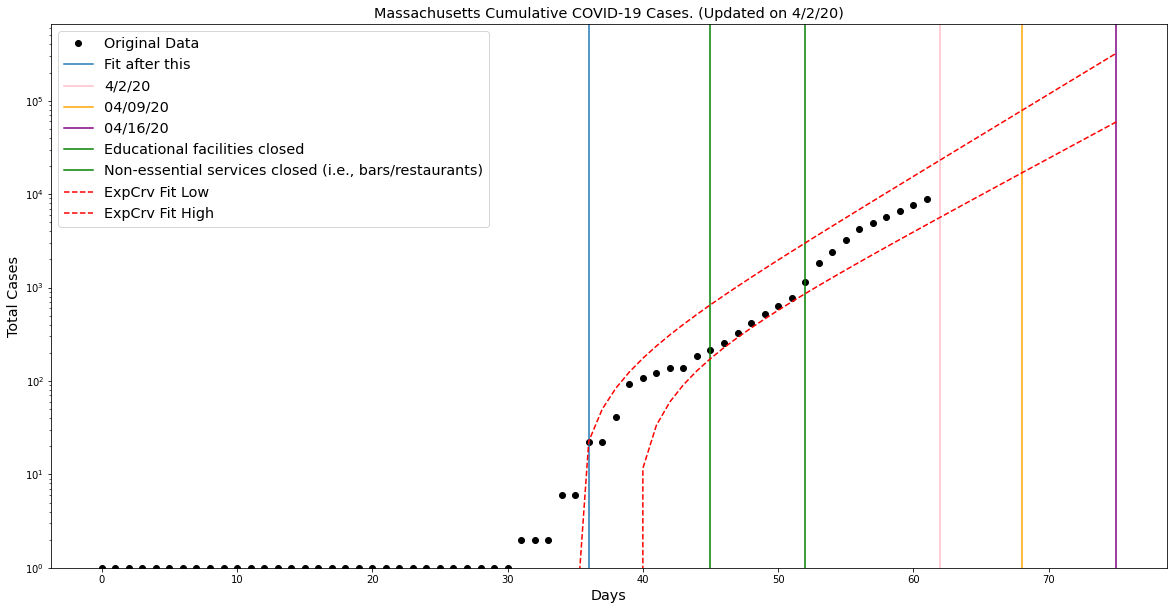

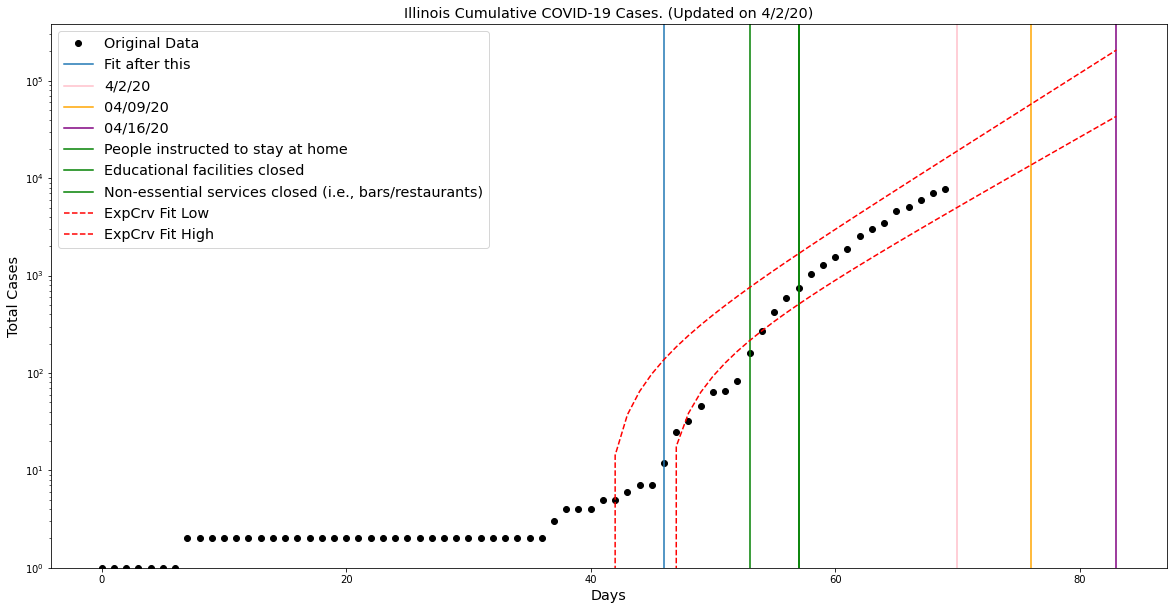

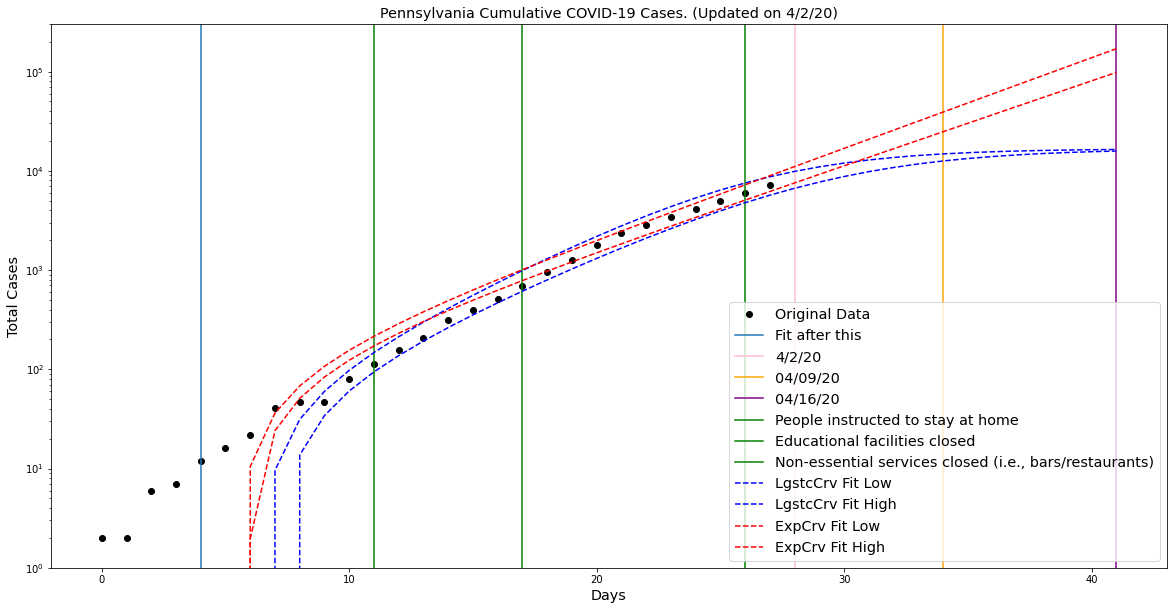

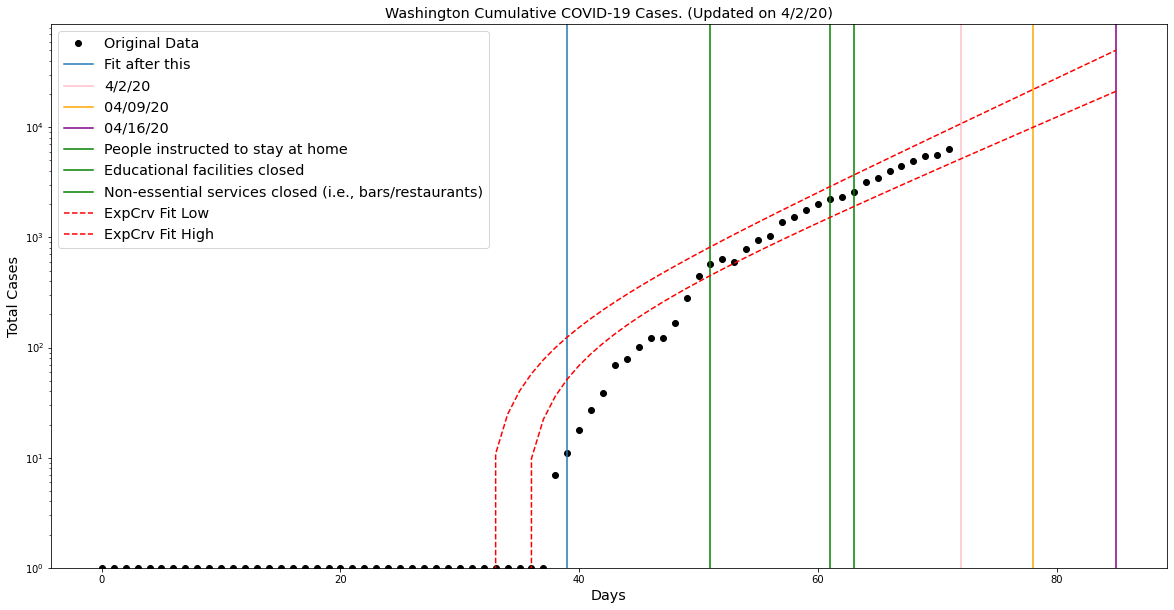

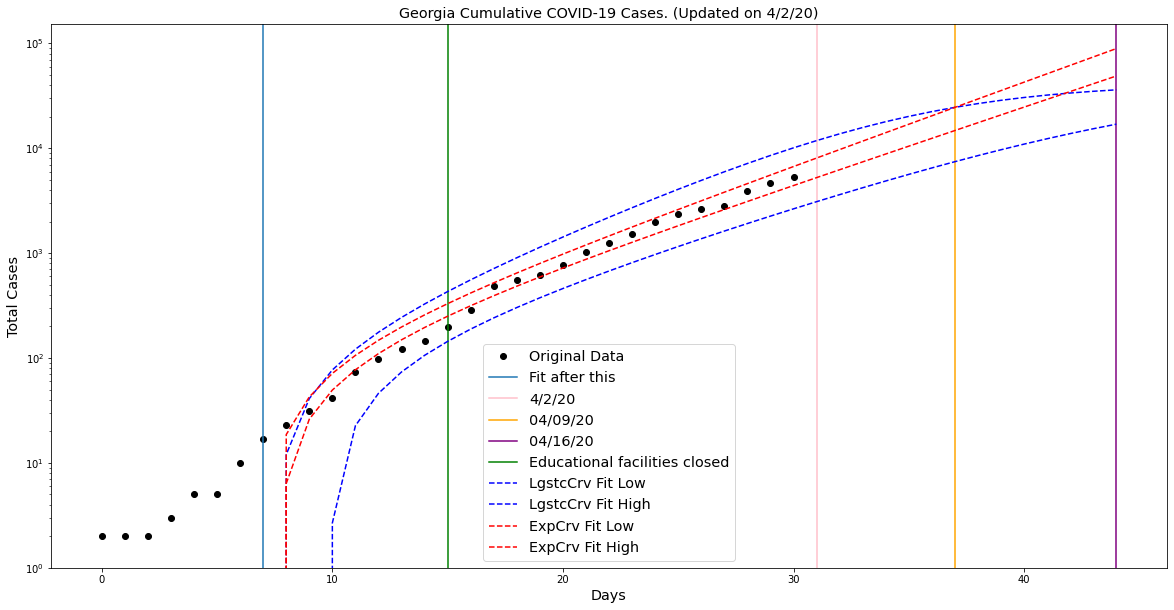

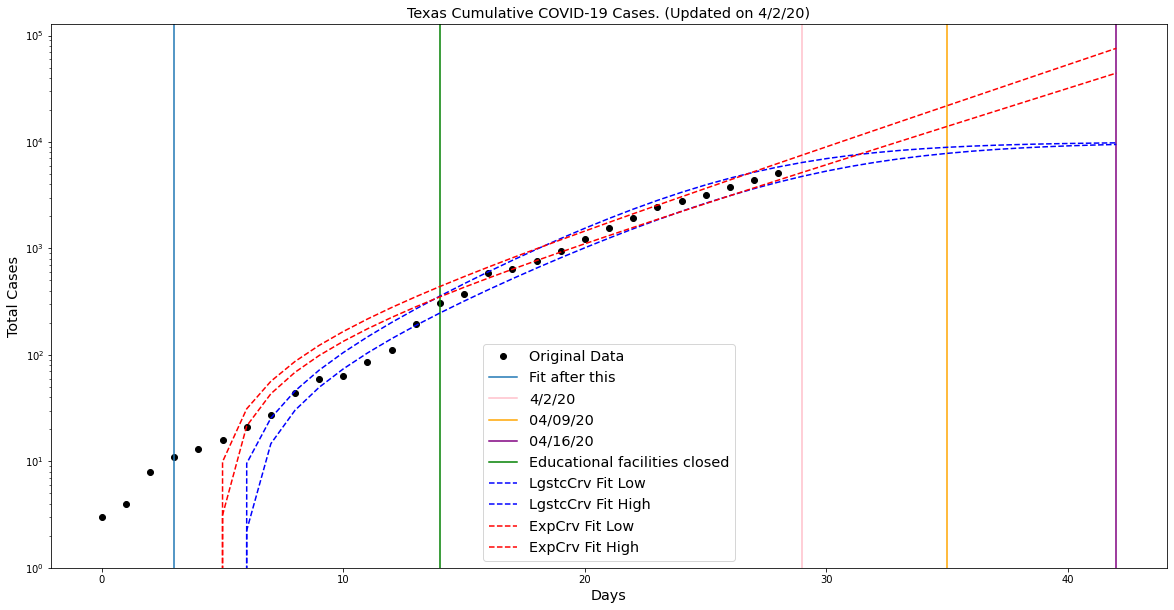

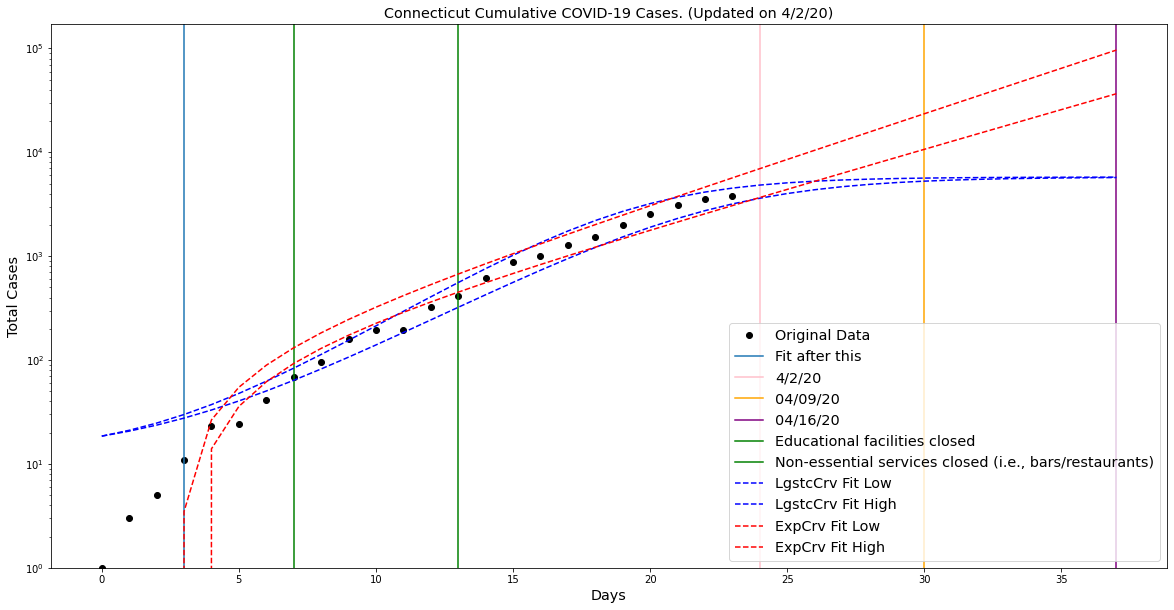

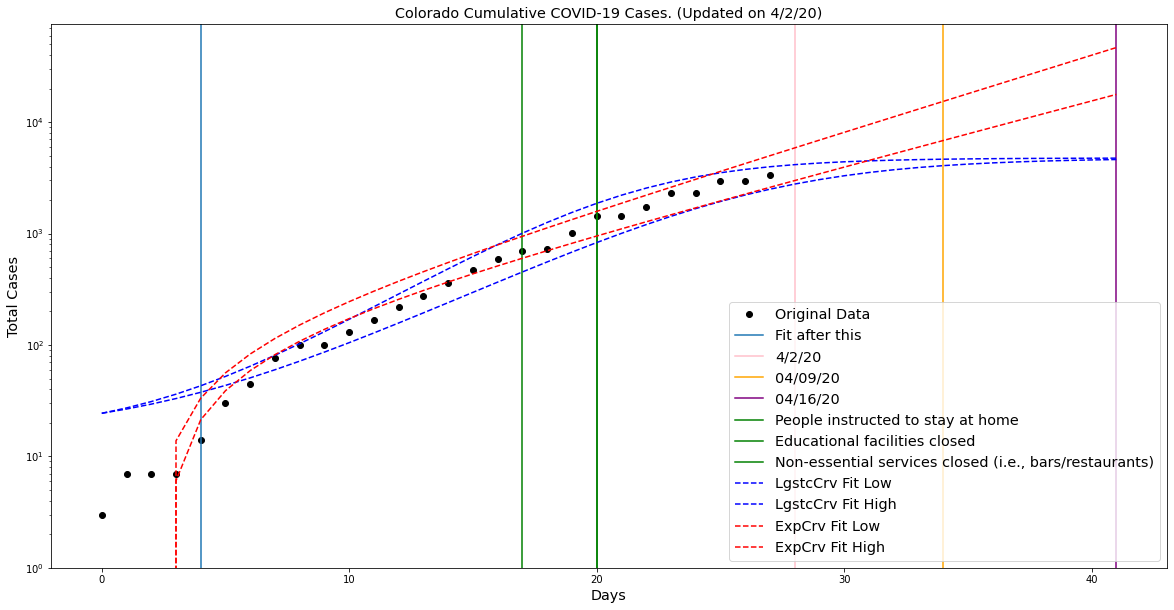

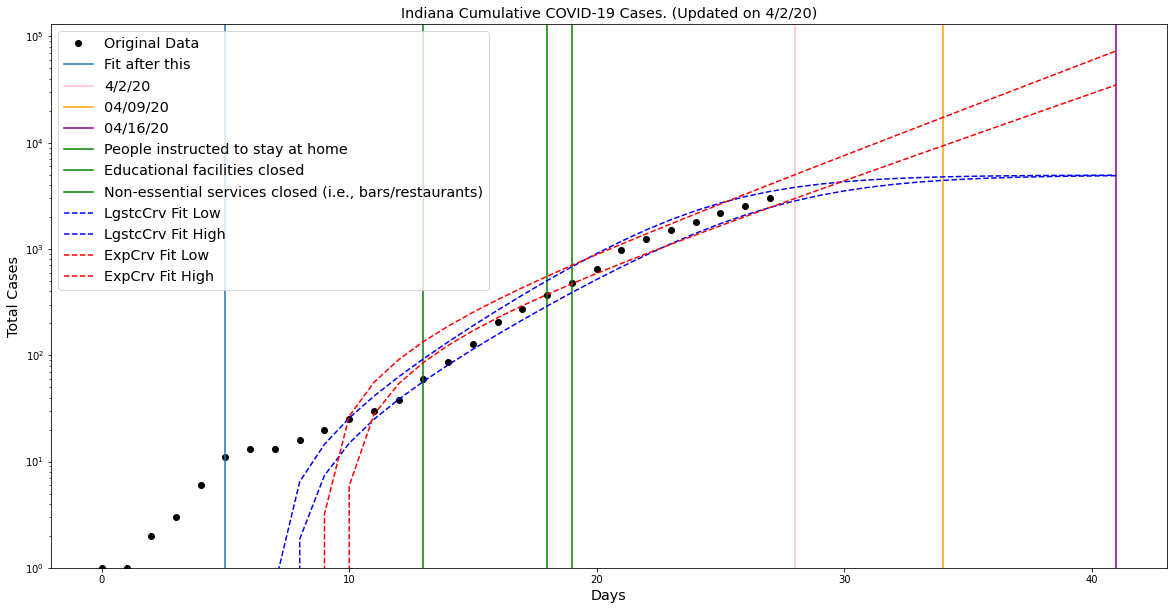

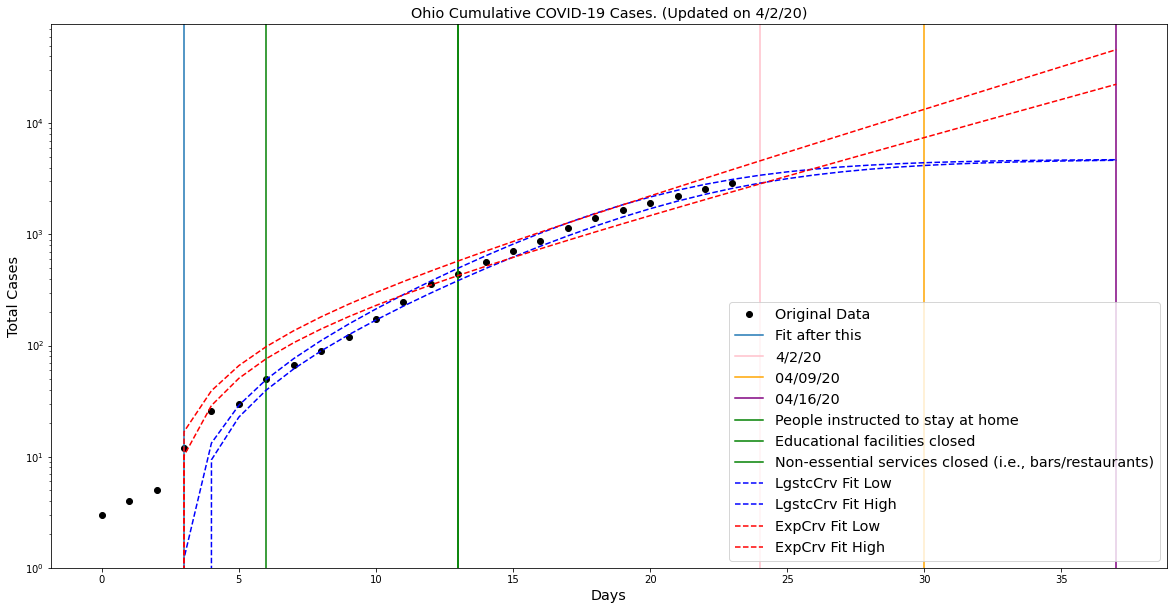

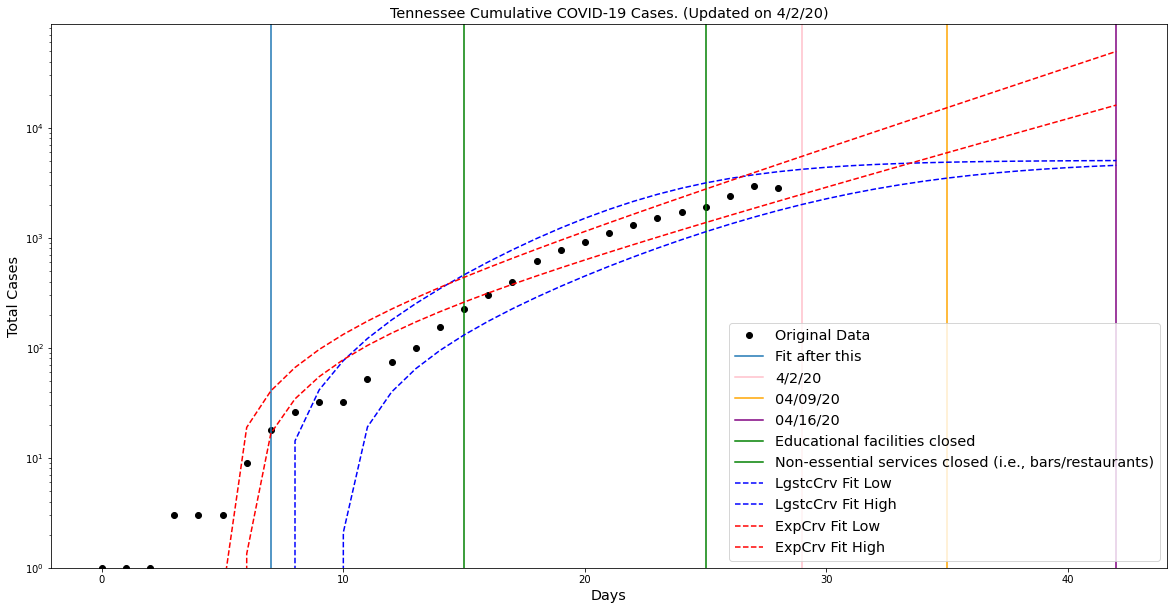

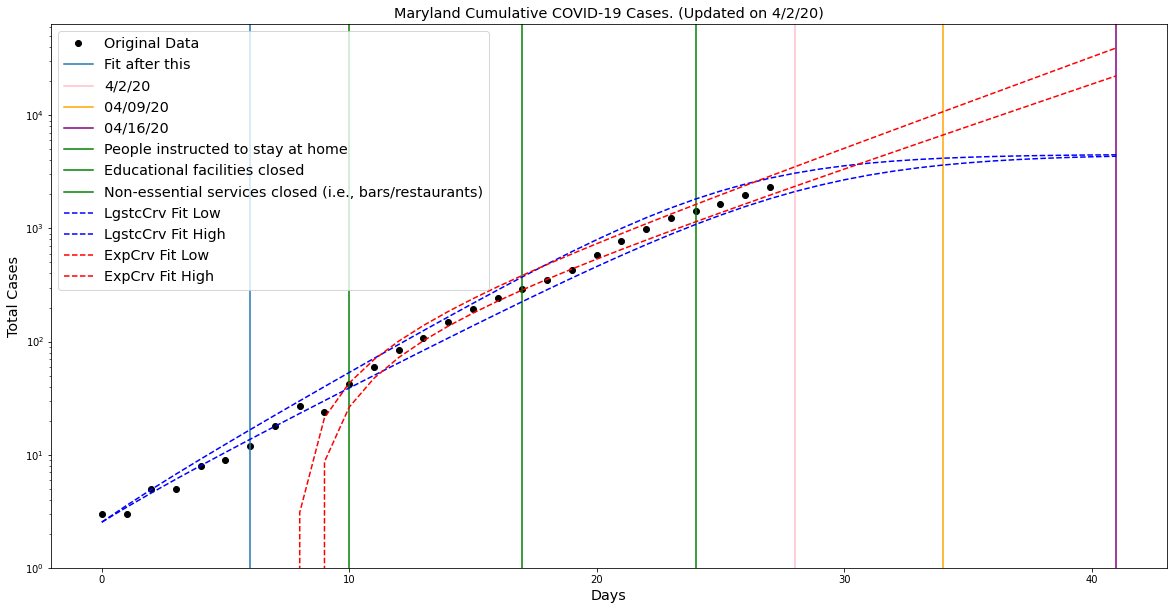

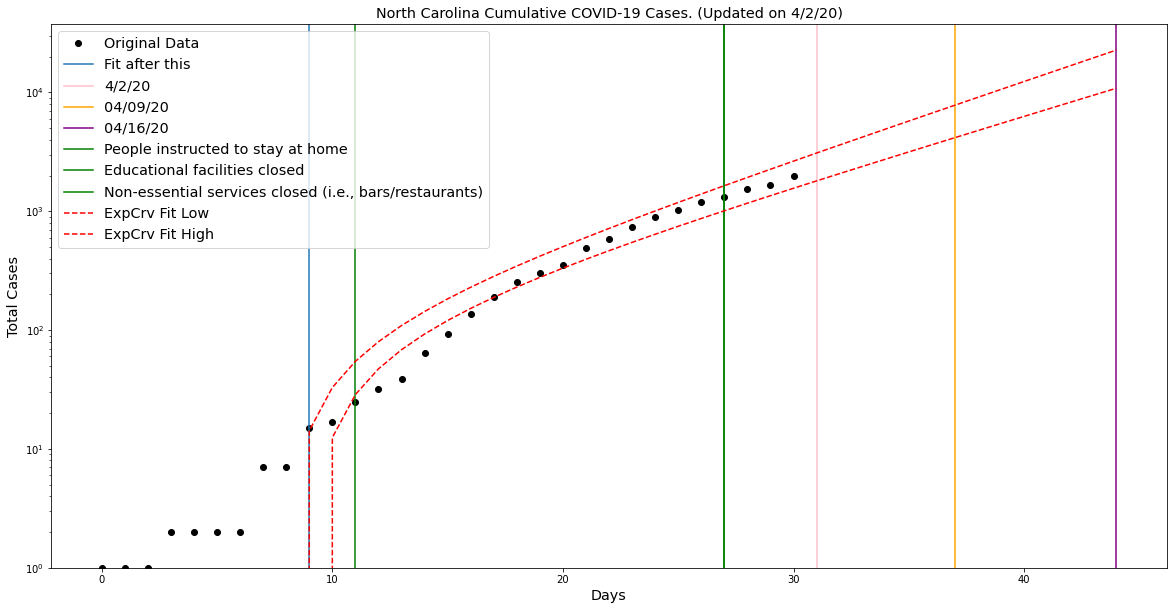

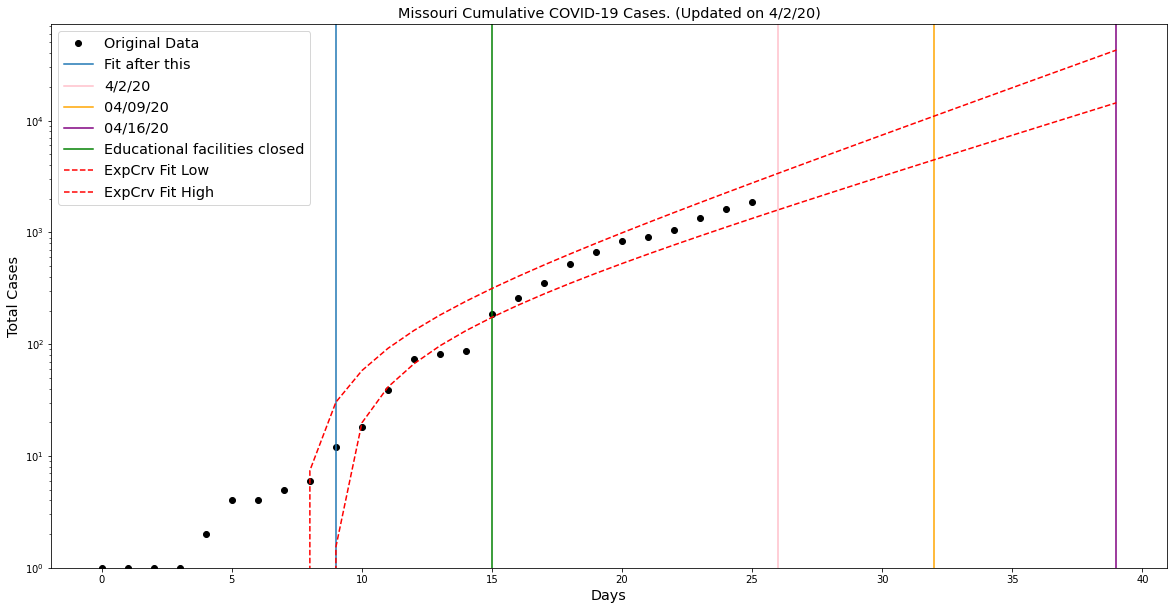

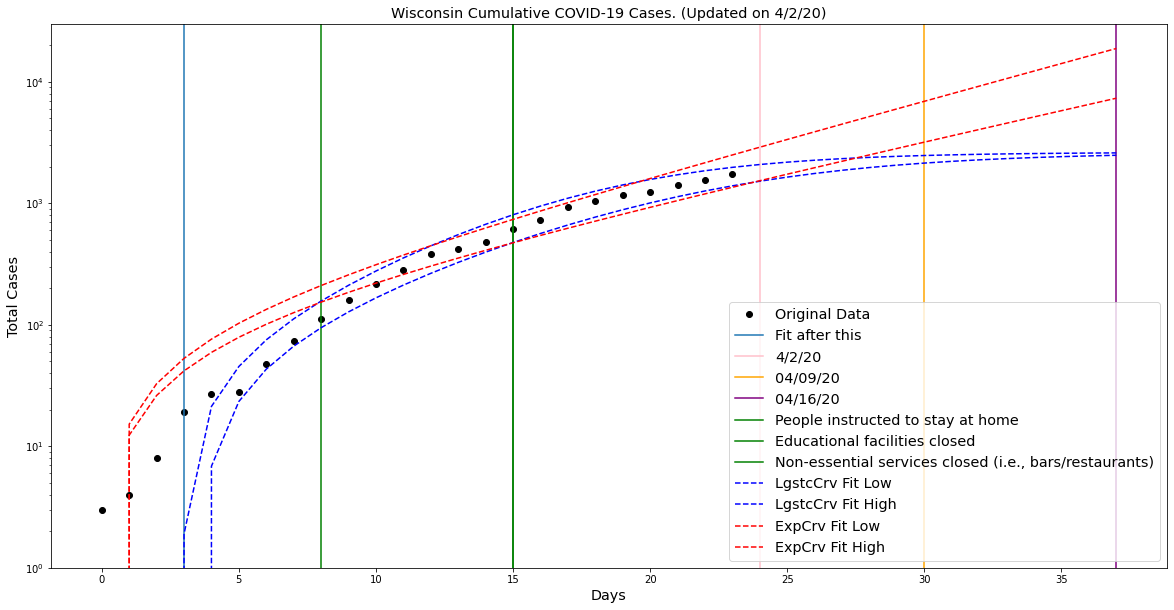

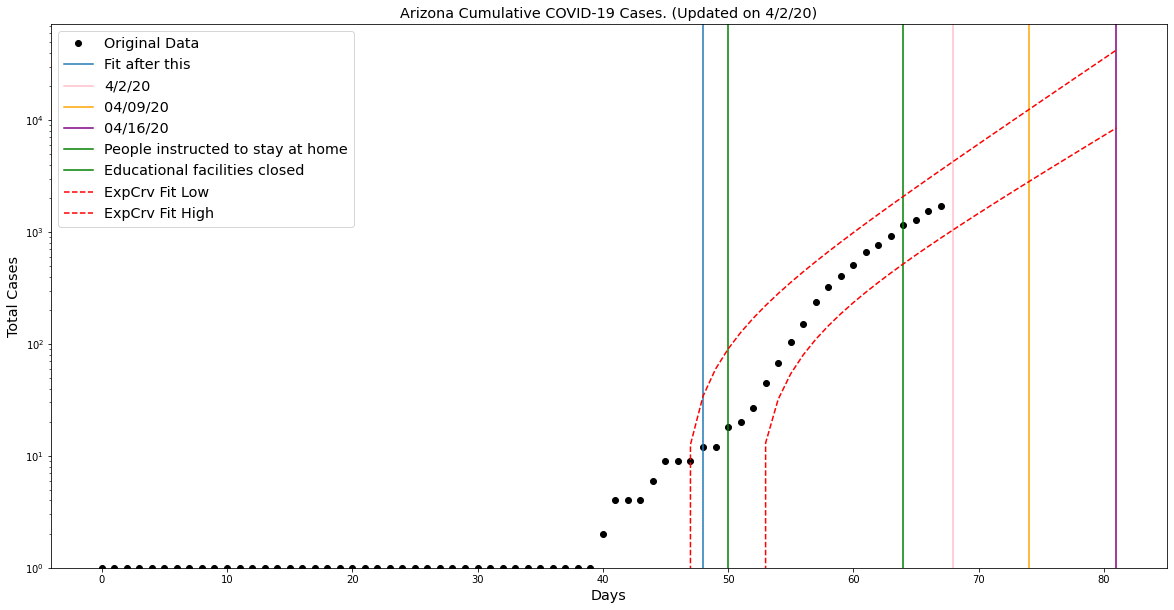

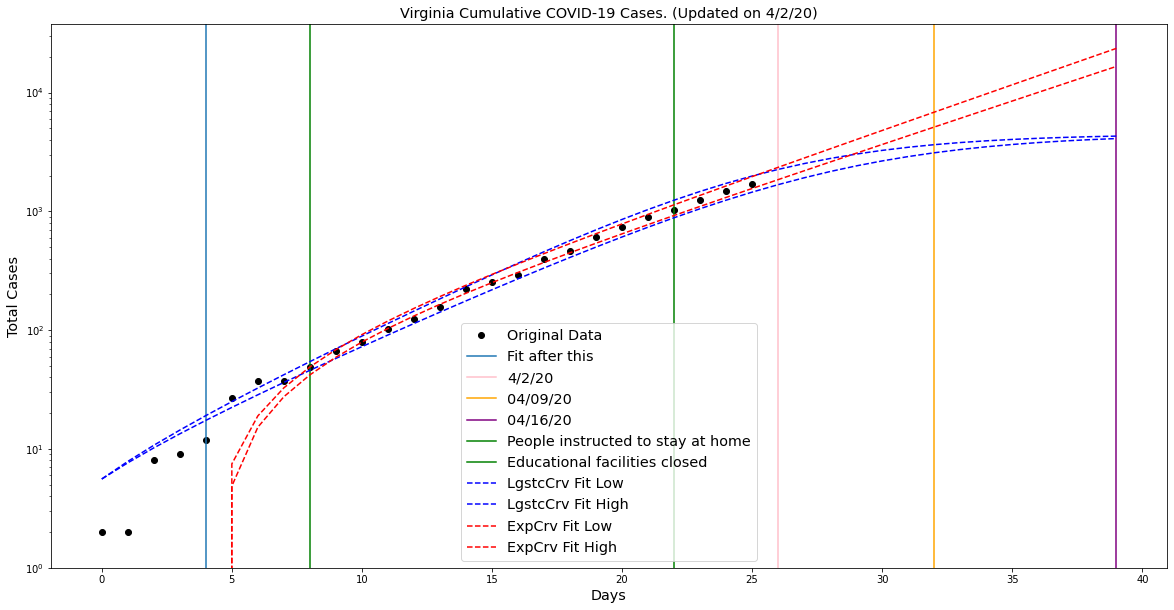

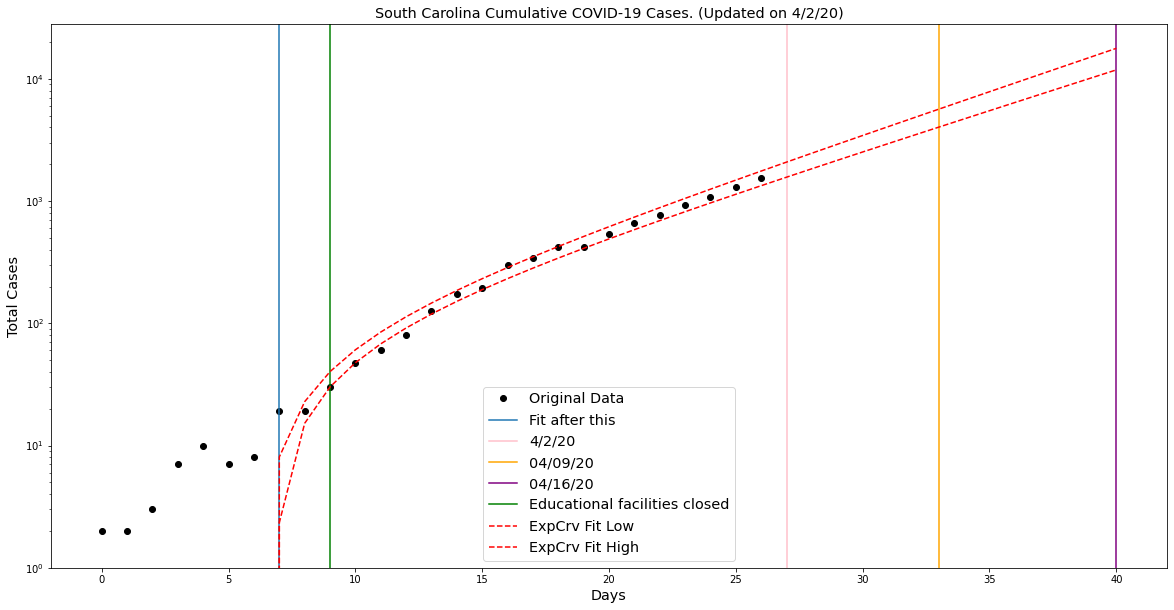

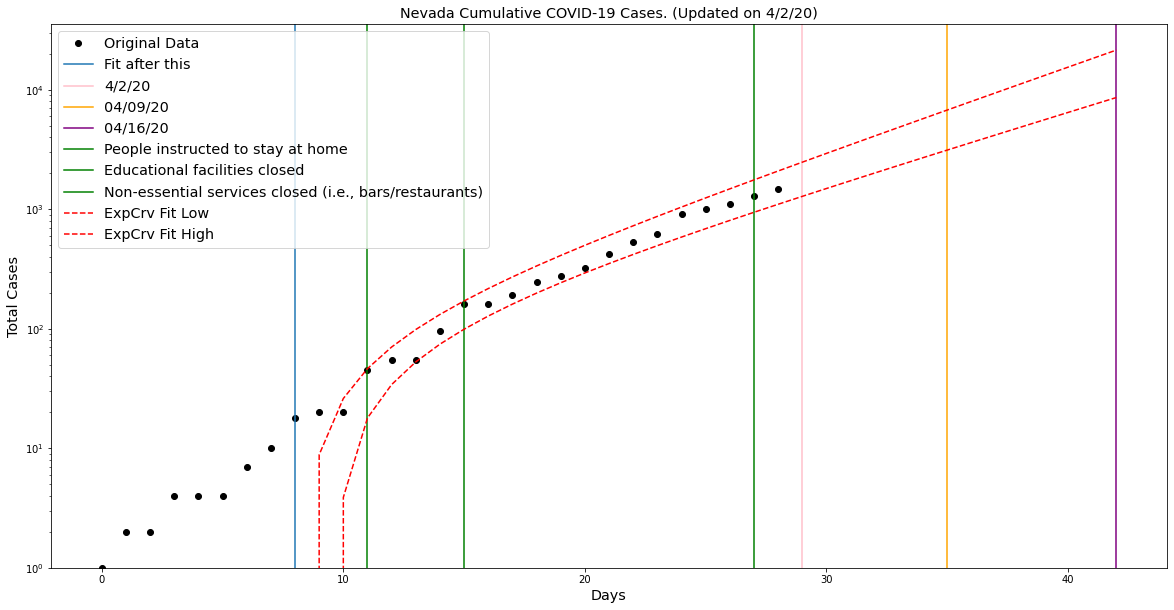

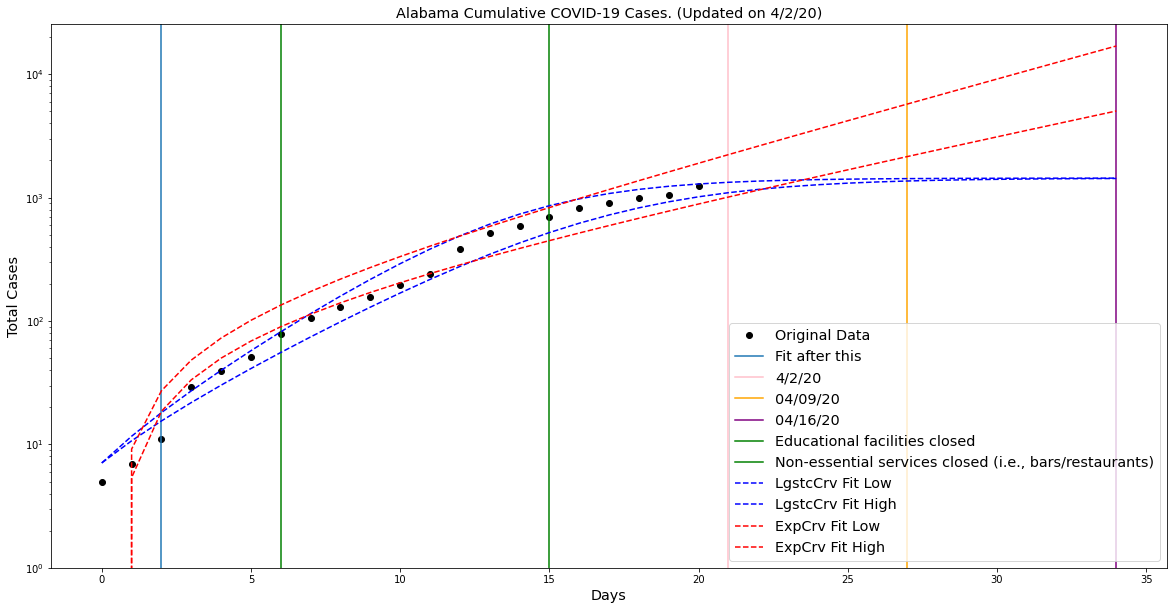

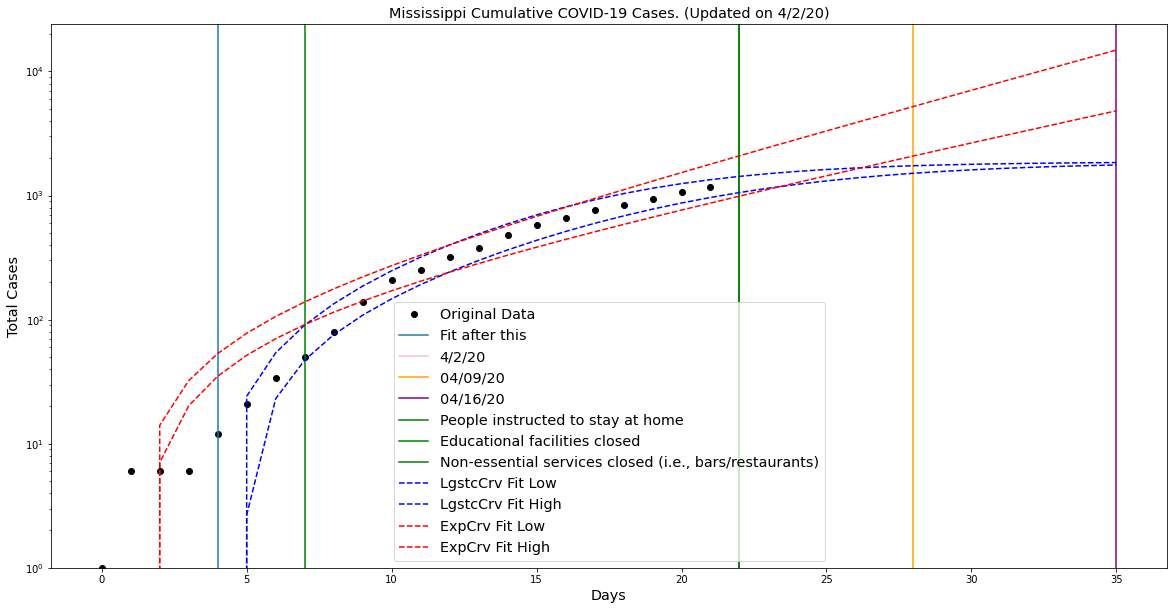

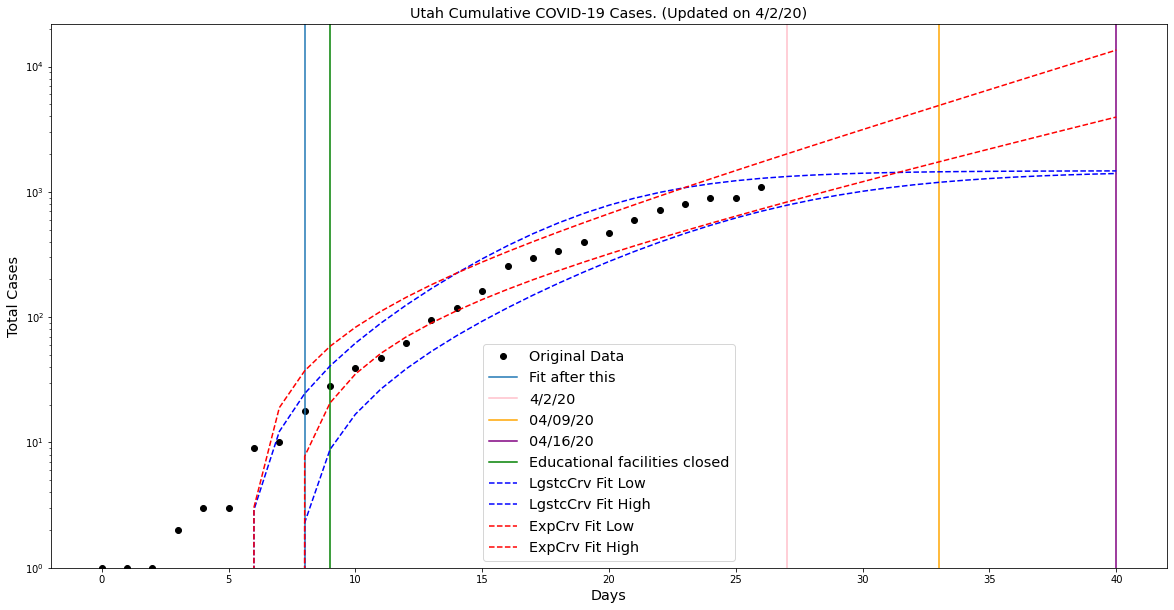

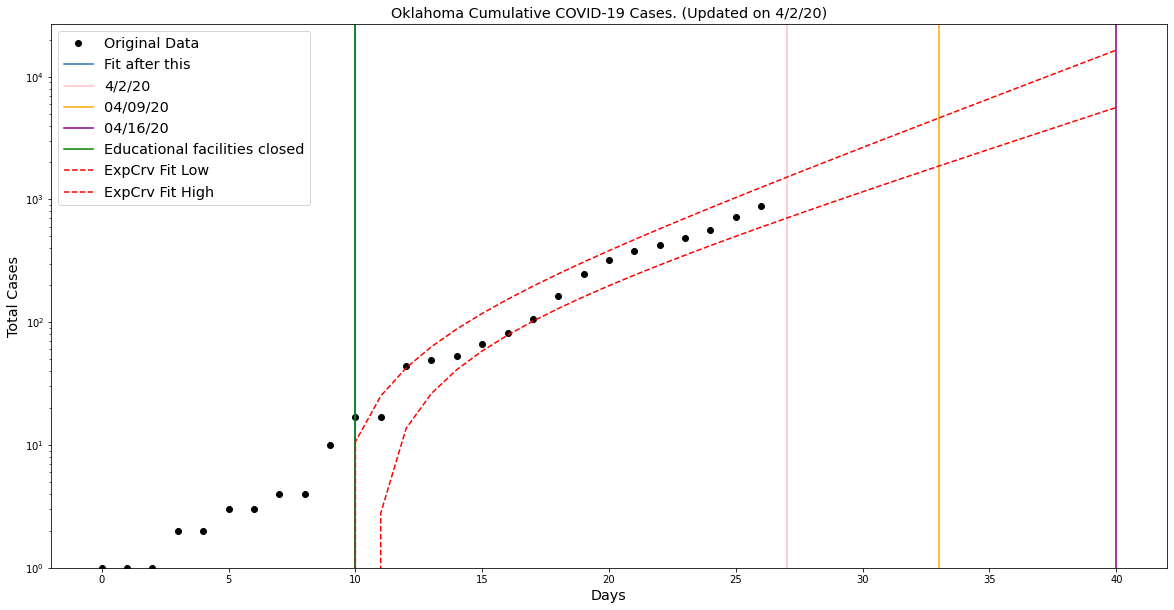

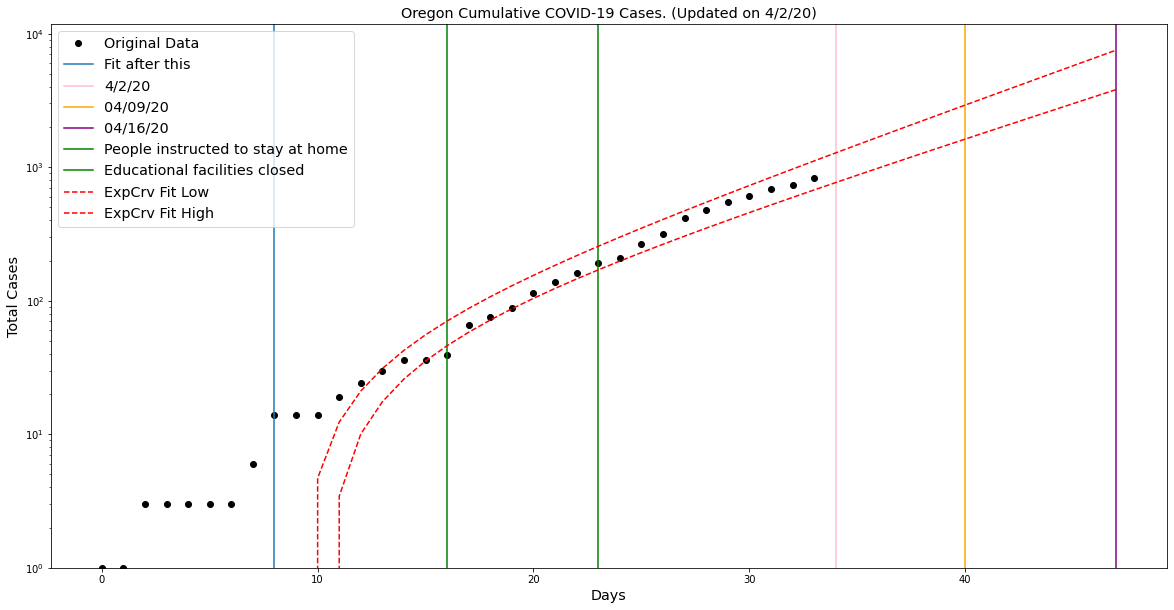

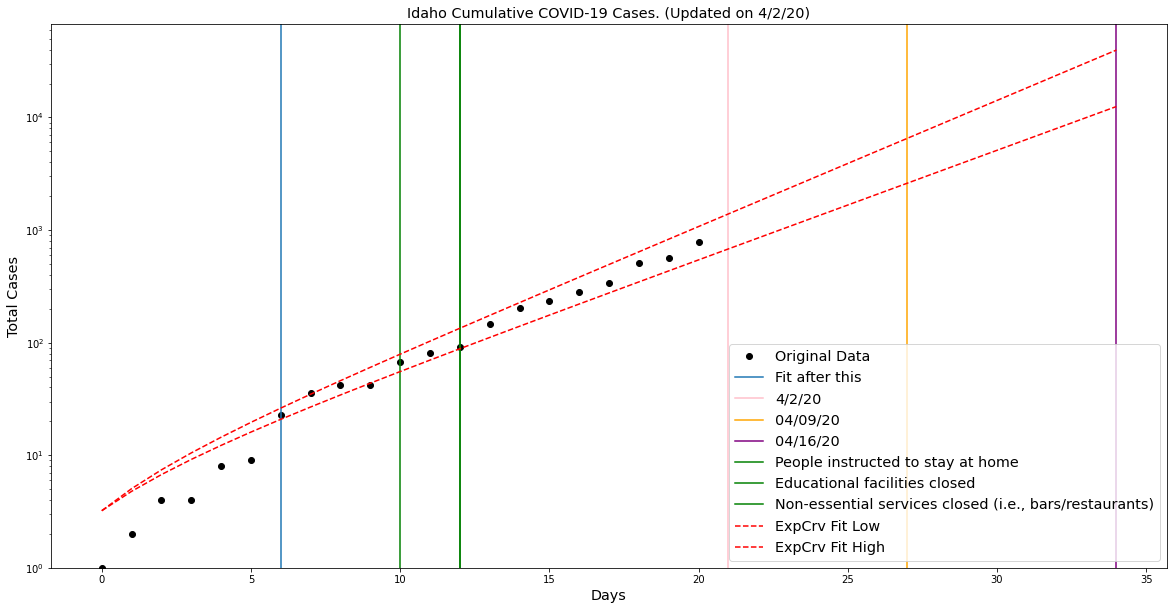

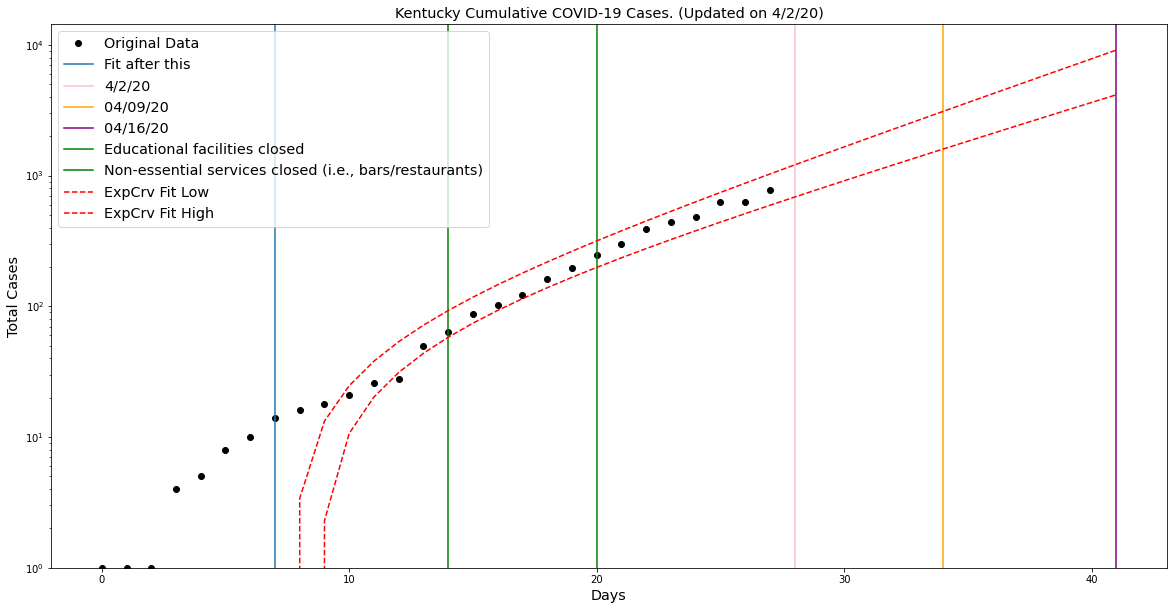

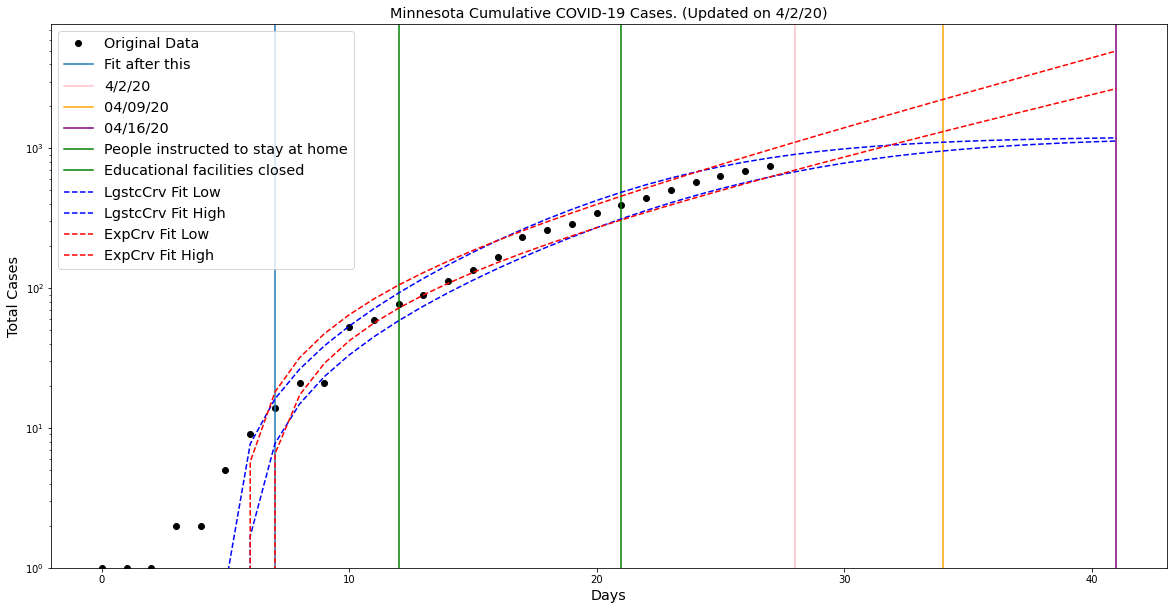

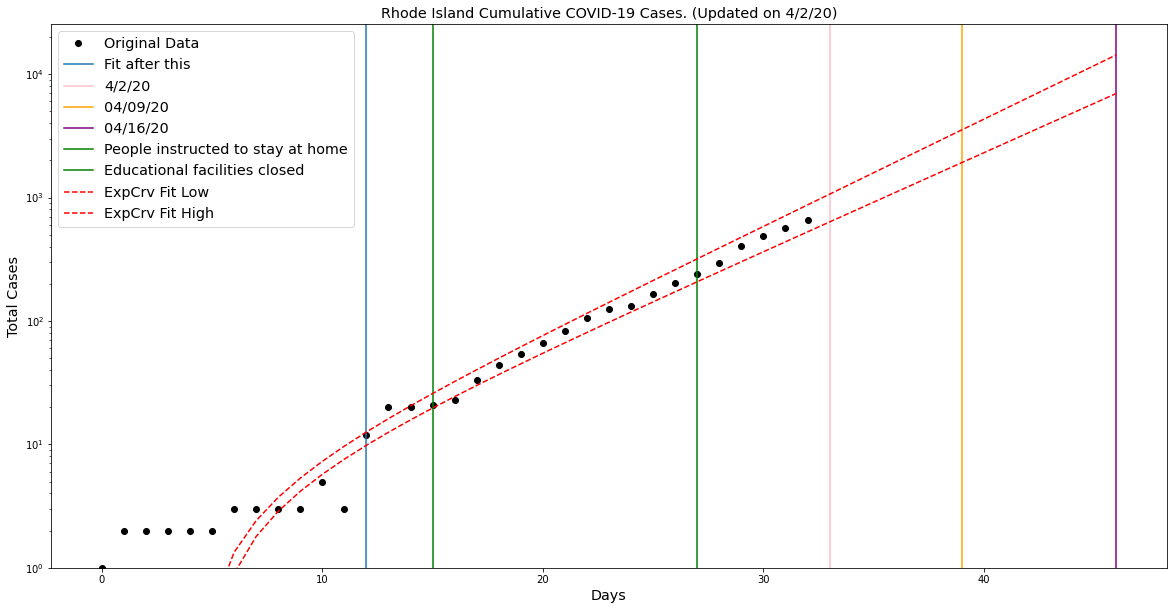

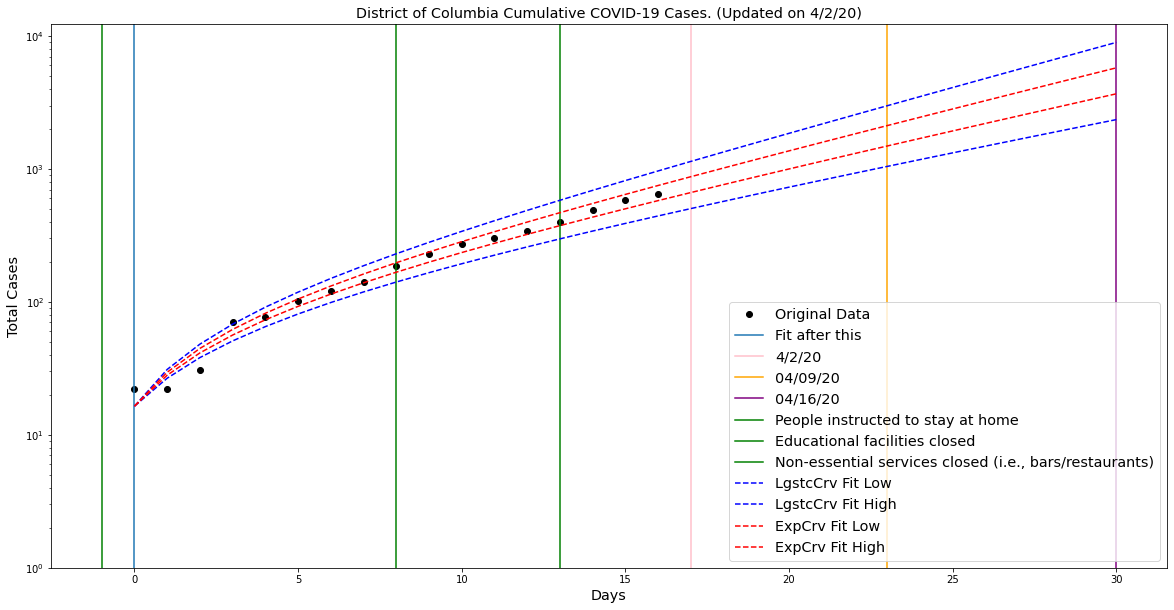

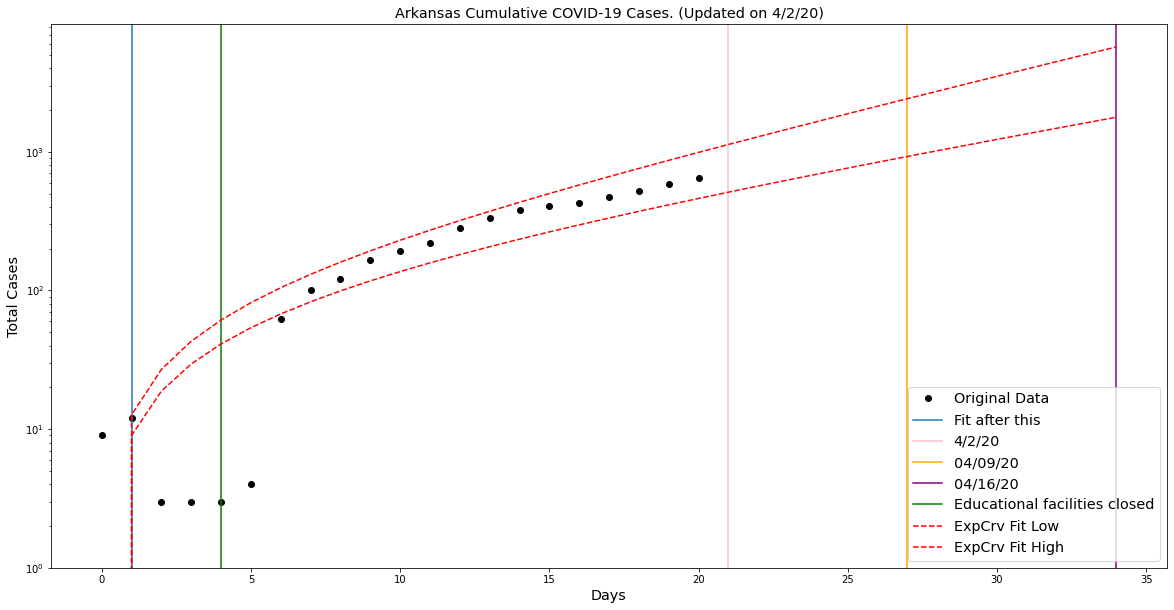

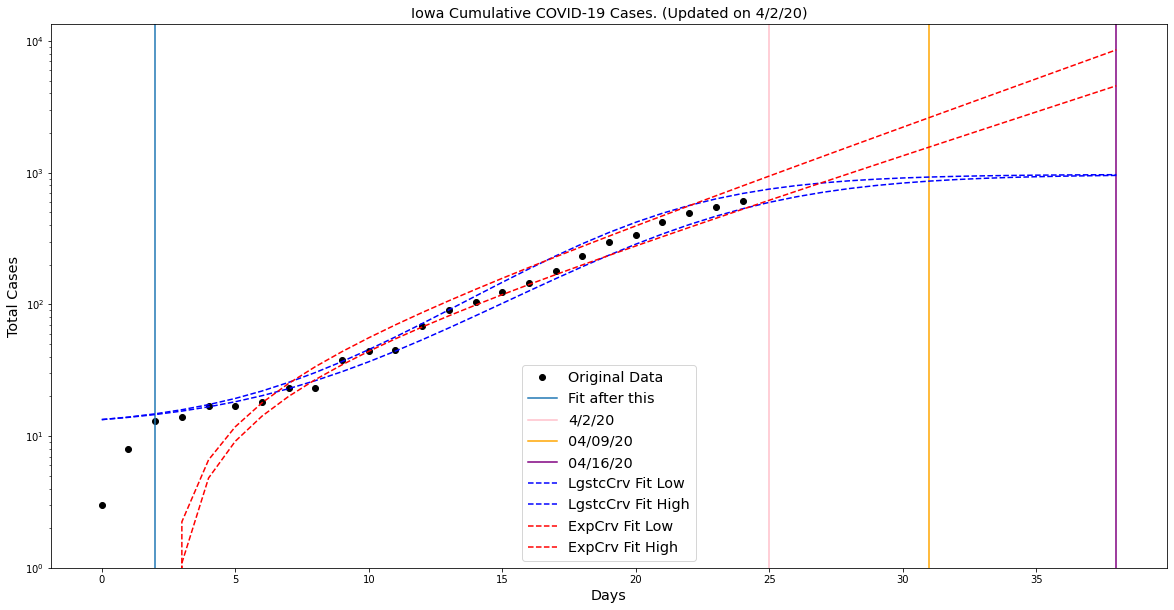

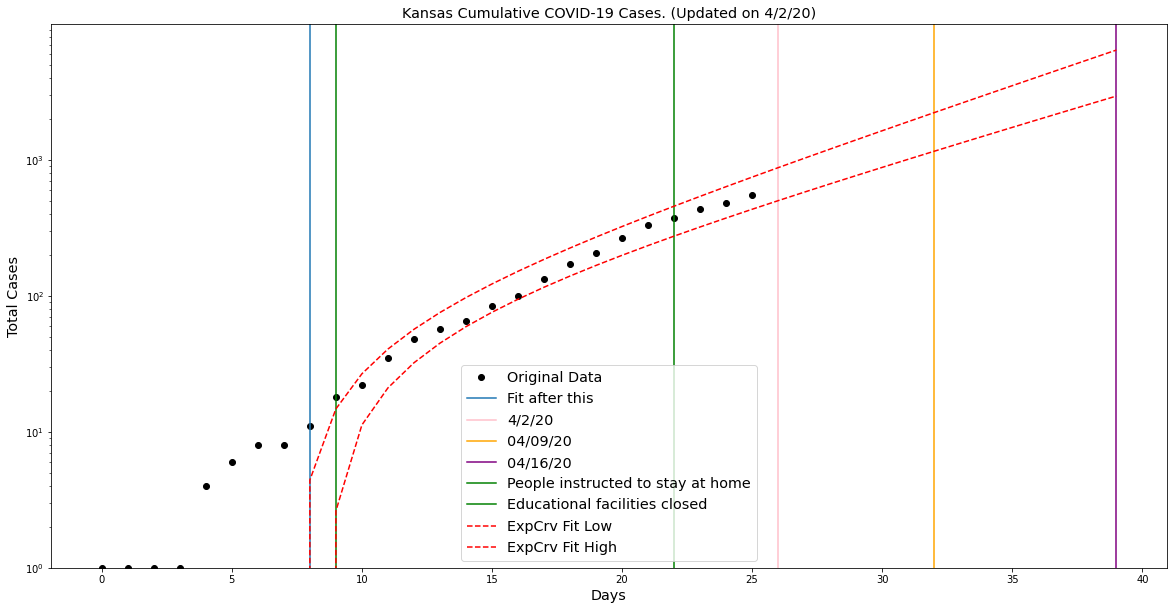

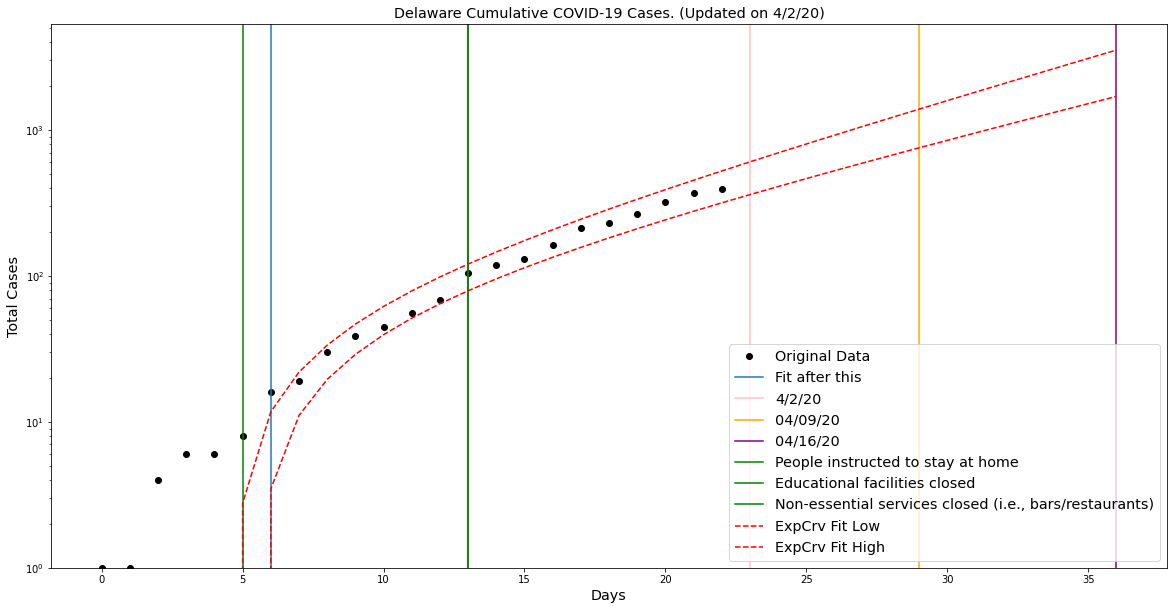

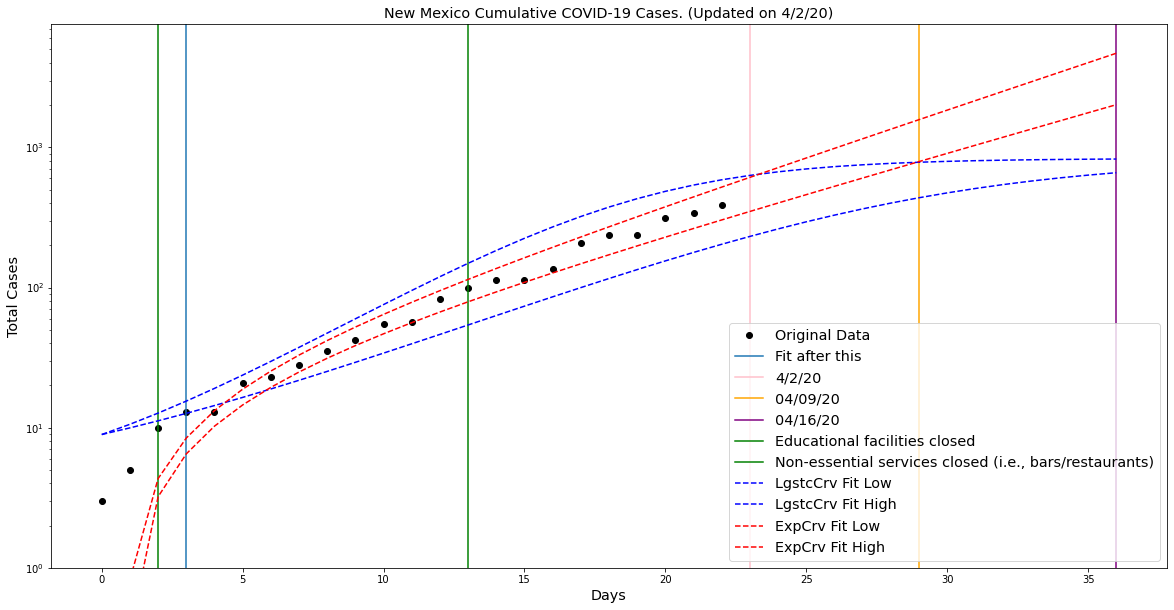

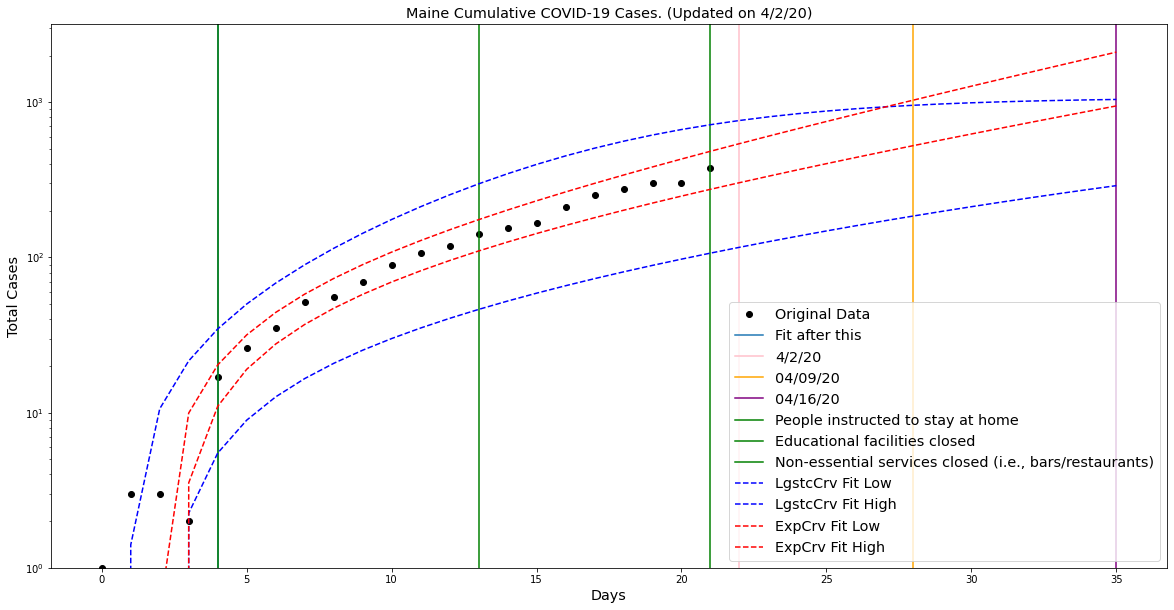

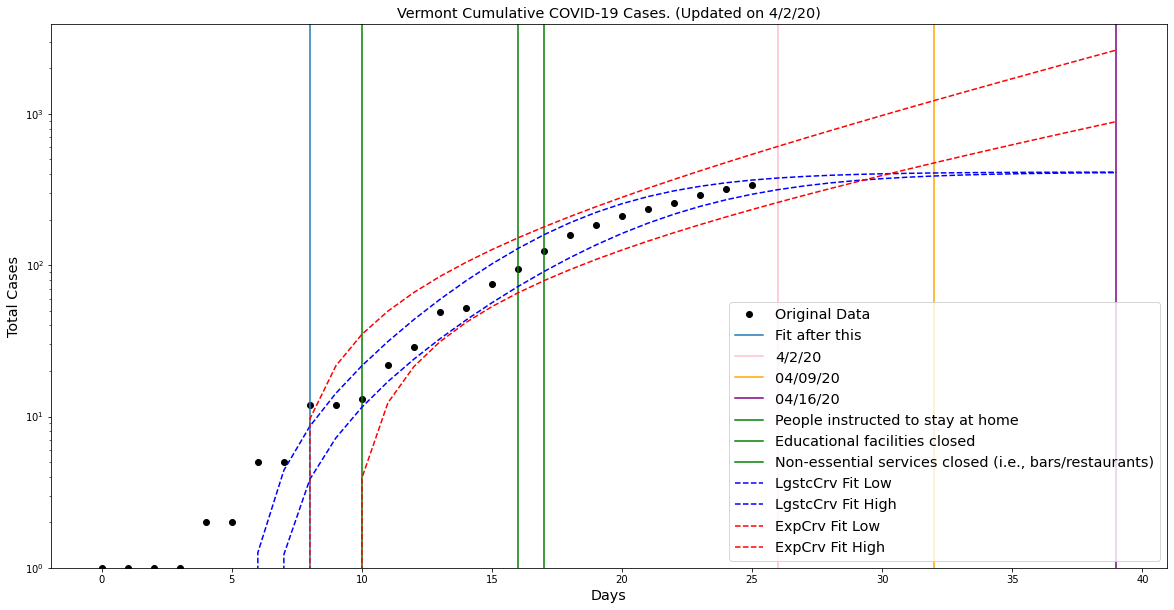

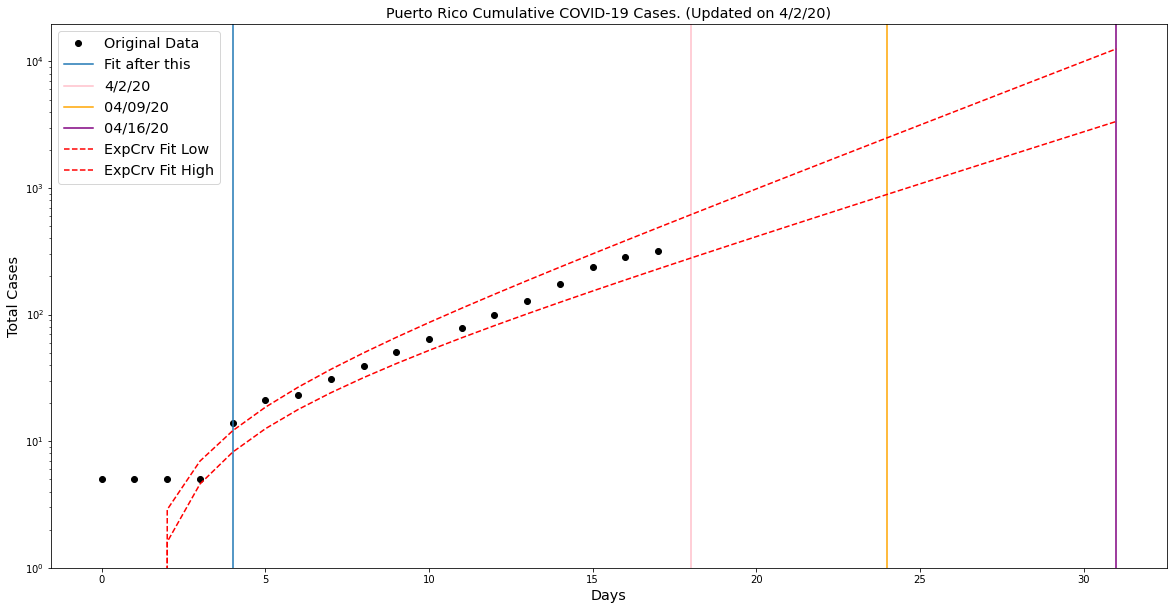

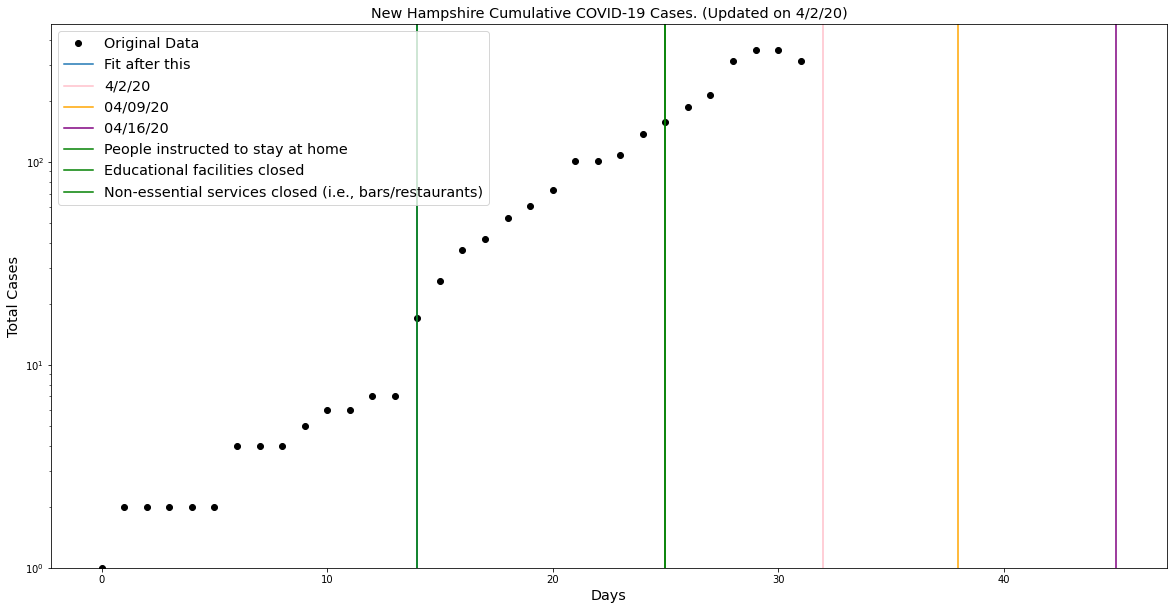

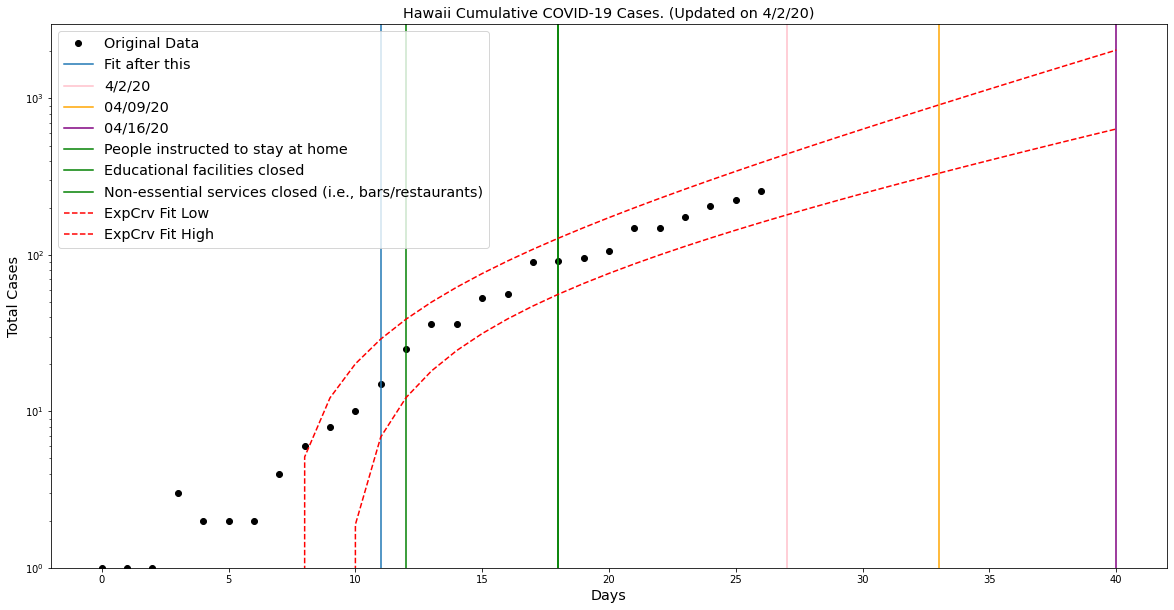

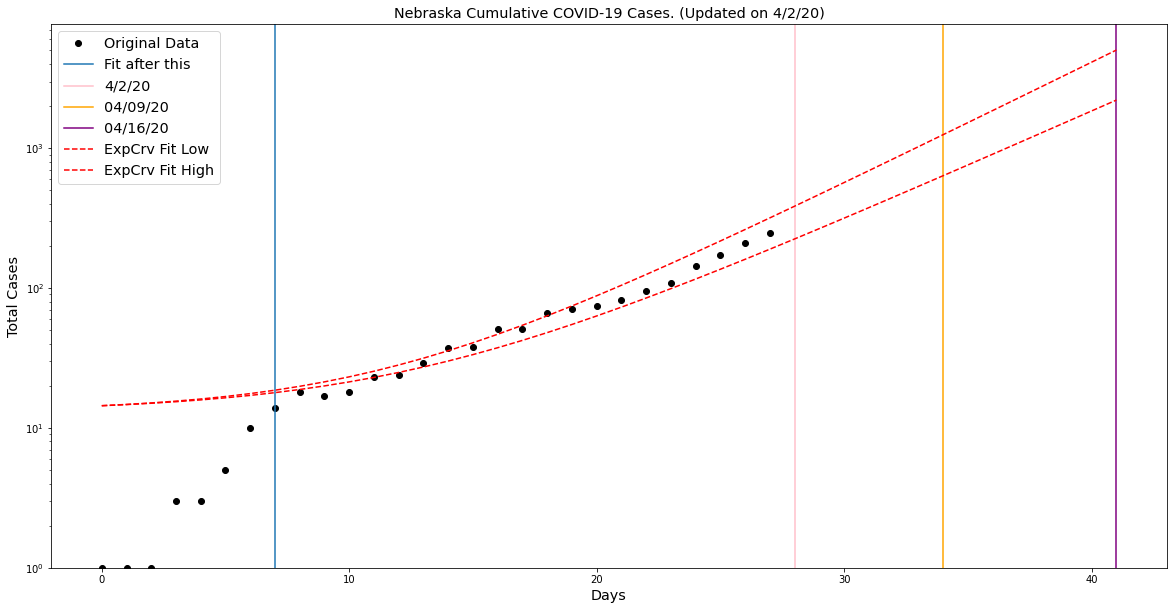

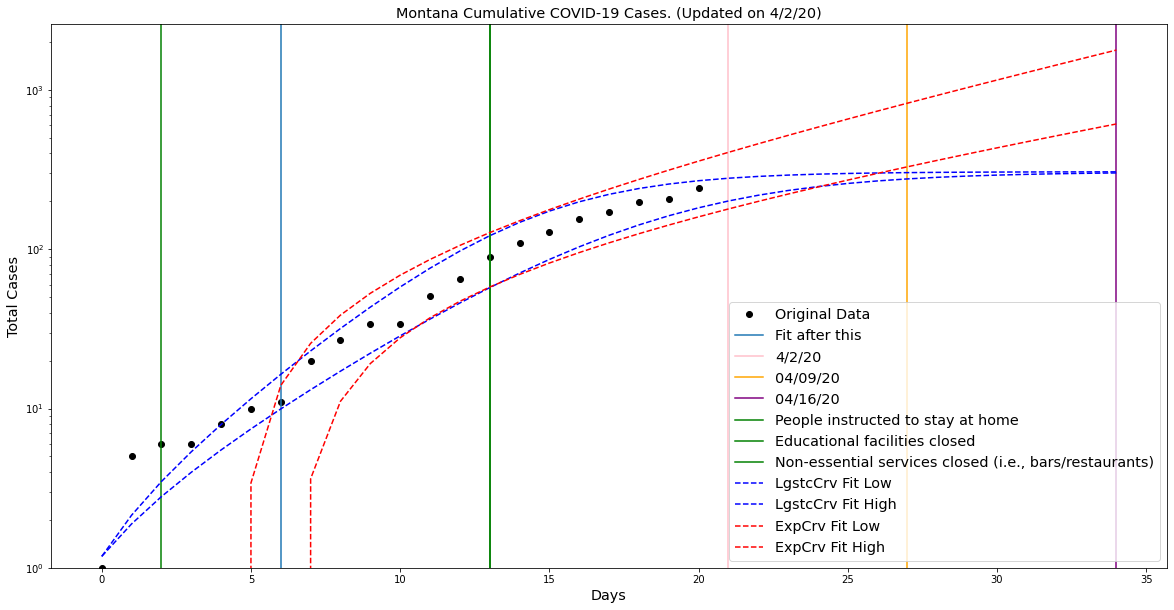

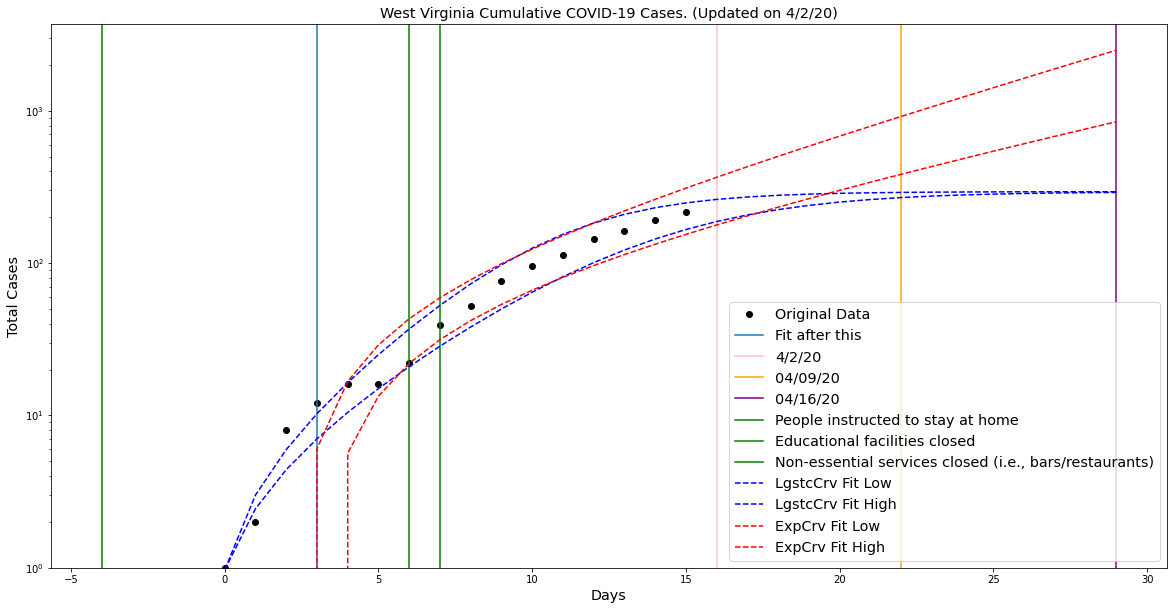

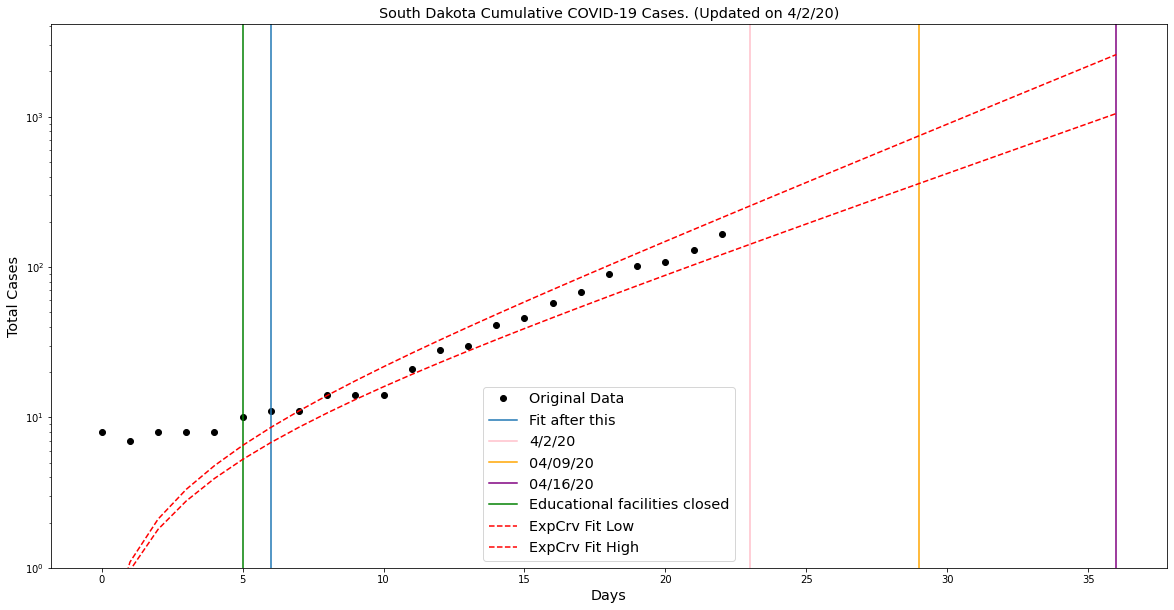

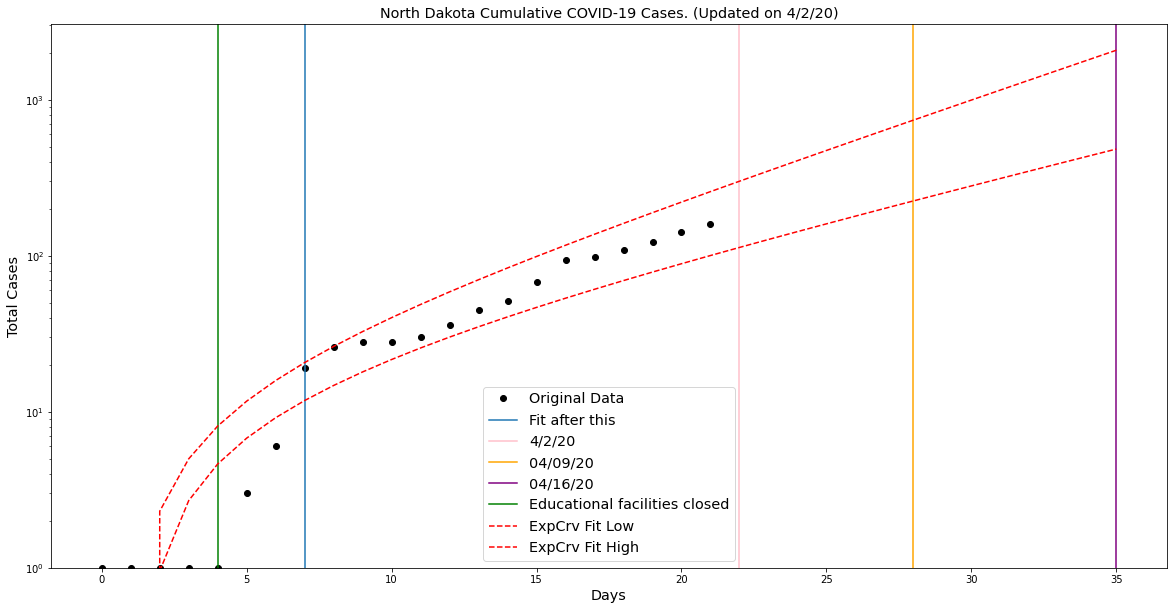

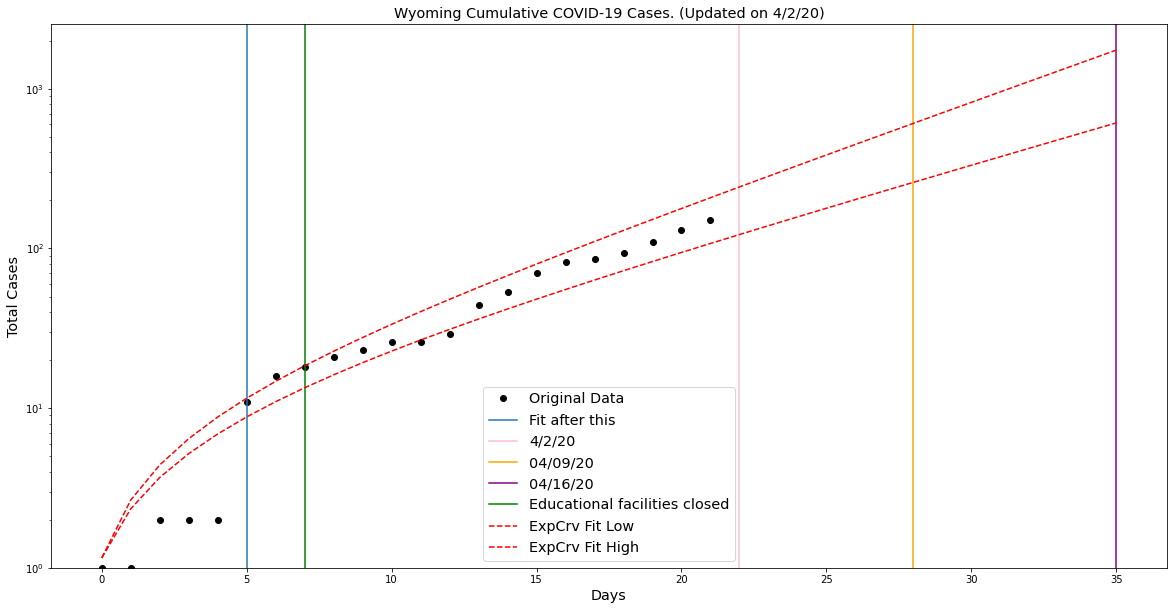

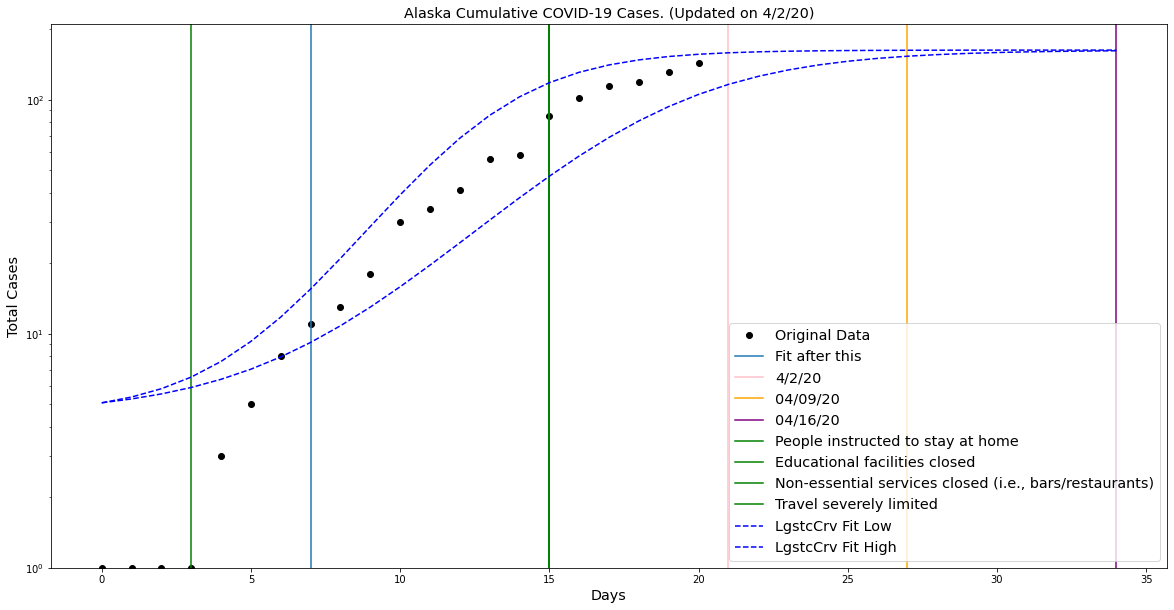

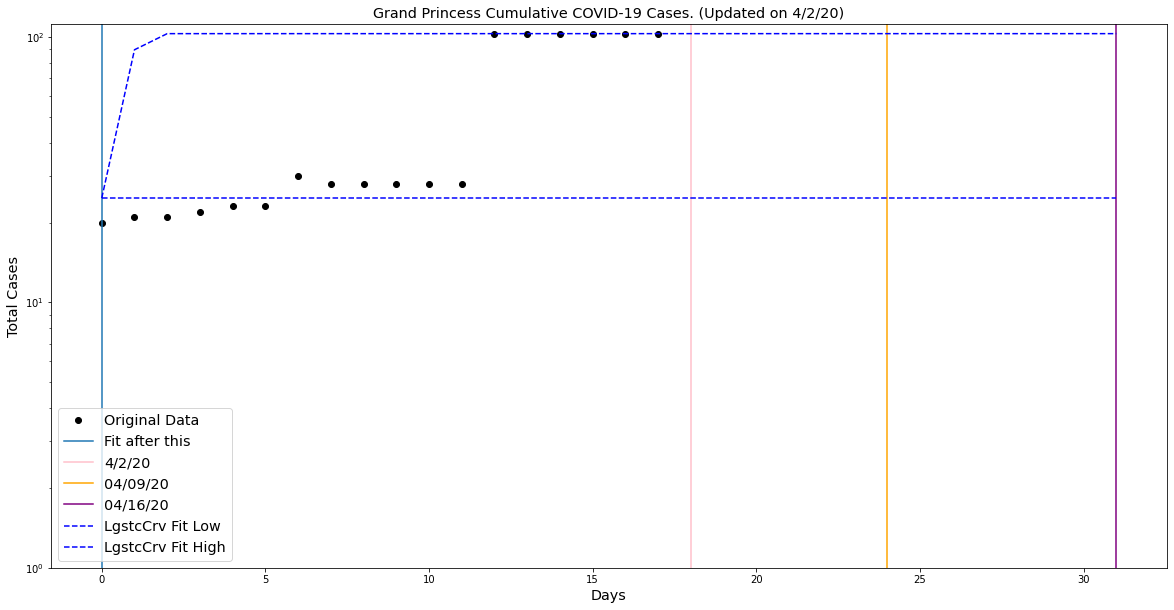

In [15]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    
    if state == "Recovered":
        continue
    
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases

In [ ]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).round(1))    

print('\n')
dt = pd.DataFrame(data = d).sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(20,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt.sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(20,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()